# Machine Learning insurance cross-selling prediction

The aim of this project is to create a predictive model able to find potential cross-selling opportunities for existing customers of an insurance company, identifying those who might be interested in purchasing an additional policy for their vehicle. The model will be built based on a dataset containing detailed information on customers and their insurance behaviour.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, 
    roc_curve, average_precision_score
)

In [2]:
# Setting some parameters for matplotlib figures
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 240
sns.set_theme()

In [3]:
# Load the original dataset
df = pd.read_csv('insurance_cross_sell.csv')
df

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                   0   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0        > 2 Years            Yes         40454.0                  26.0   
1         1-2 Year             No         33536.0                  26.0   
2        > 2 Years            Yes         38294.0                  26.0   
3         < 1 Year             No         28619.0                 152.0   
4         < 1 Year             No         27496.0                 152.0   
...            ...            ...             ...                   ...   
381104    1-2 Year             No         30170.0                  26.0   
381105    < 1 Year             No         40016.0                 152.0   
381106    < 1 Year             No         35118.0                 160.0   
381107   > 2 Years            Yes         44617.0                 124.0   
381108    1-2 Year             No         41777.0                  26.0   

        Vintage  Response  
0           217         1  
1           183         0  
2            27         1  
3           203         0  
4            39         0  
...         ...       ...  
381104       88         0  
381105      131         0  
381106      161         0  
381107       74         0  
381108      237         0  

[381109 rows x 12 columns]

## Dataset exploration

First, a preliminary exploration of the dataset is peformed, to better understand the distribution of features and target variables.

### Dataset overview

In [4]:
# Dataset size and first 5 rows
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset size: 381109 rows and 12 columns


id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

In [34]:
# General information on the dataset
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [35]:
# Count of null values per column
print("Null values:")
df.isnull().sum()

Null values:


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

None of the variables has null values, so no further management (such as dropping or imputation of missing values) is required.

In [ ]:
# General descriptive statistics
df.describe()

id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.000000   
25%              0.000000    24405.000000             29.000000   
50%              0.000000    31669.000000            133.000000   
75%              1.000000    39400.000000            152.000000   
max              1.000000   540165.000000            163.000000   

             Vintage       Response  
count  381109.000000  381109.000000  
mean      154.347397       0.122563  
std        83.671304       0.327936  
min        10.000000       0.000000  
25%        82.000000       0.000000  
50%       154.000000       0.000000  
75%       227.000000       0.000000  
max       299.000000       1.000000

### Analysis of the target variable "Response"

Here, the distribution of the 'Response' variable is analysed, to identify possible imbalances in samples (customers response).

In [37]:
response_count = df['Response'].value_counts()
response_percentage = df['Response'].value_counts(normalize=True) * 100

print("\nDistribution of the Response variable:")
print(f"  0 (Negative): {response_count[0]} customers ({response_percentage[0]:.2f}%)")
print(f"  1 (Positive): {response_count[1]} customers ({response_percentage[1]:.2f}%)")


Distribution of the Response variable:
  0 (Negative): 334399 customers (87.74%)
  1 (Positive): 46710 customers (12.26%)


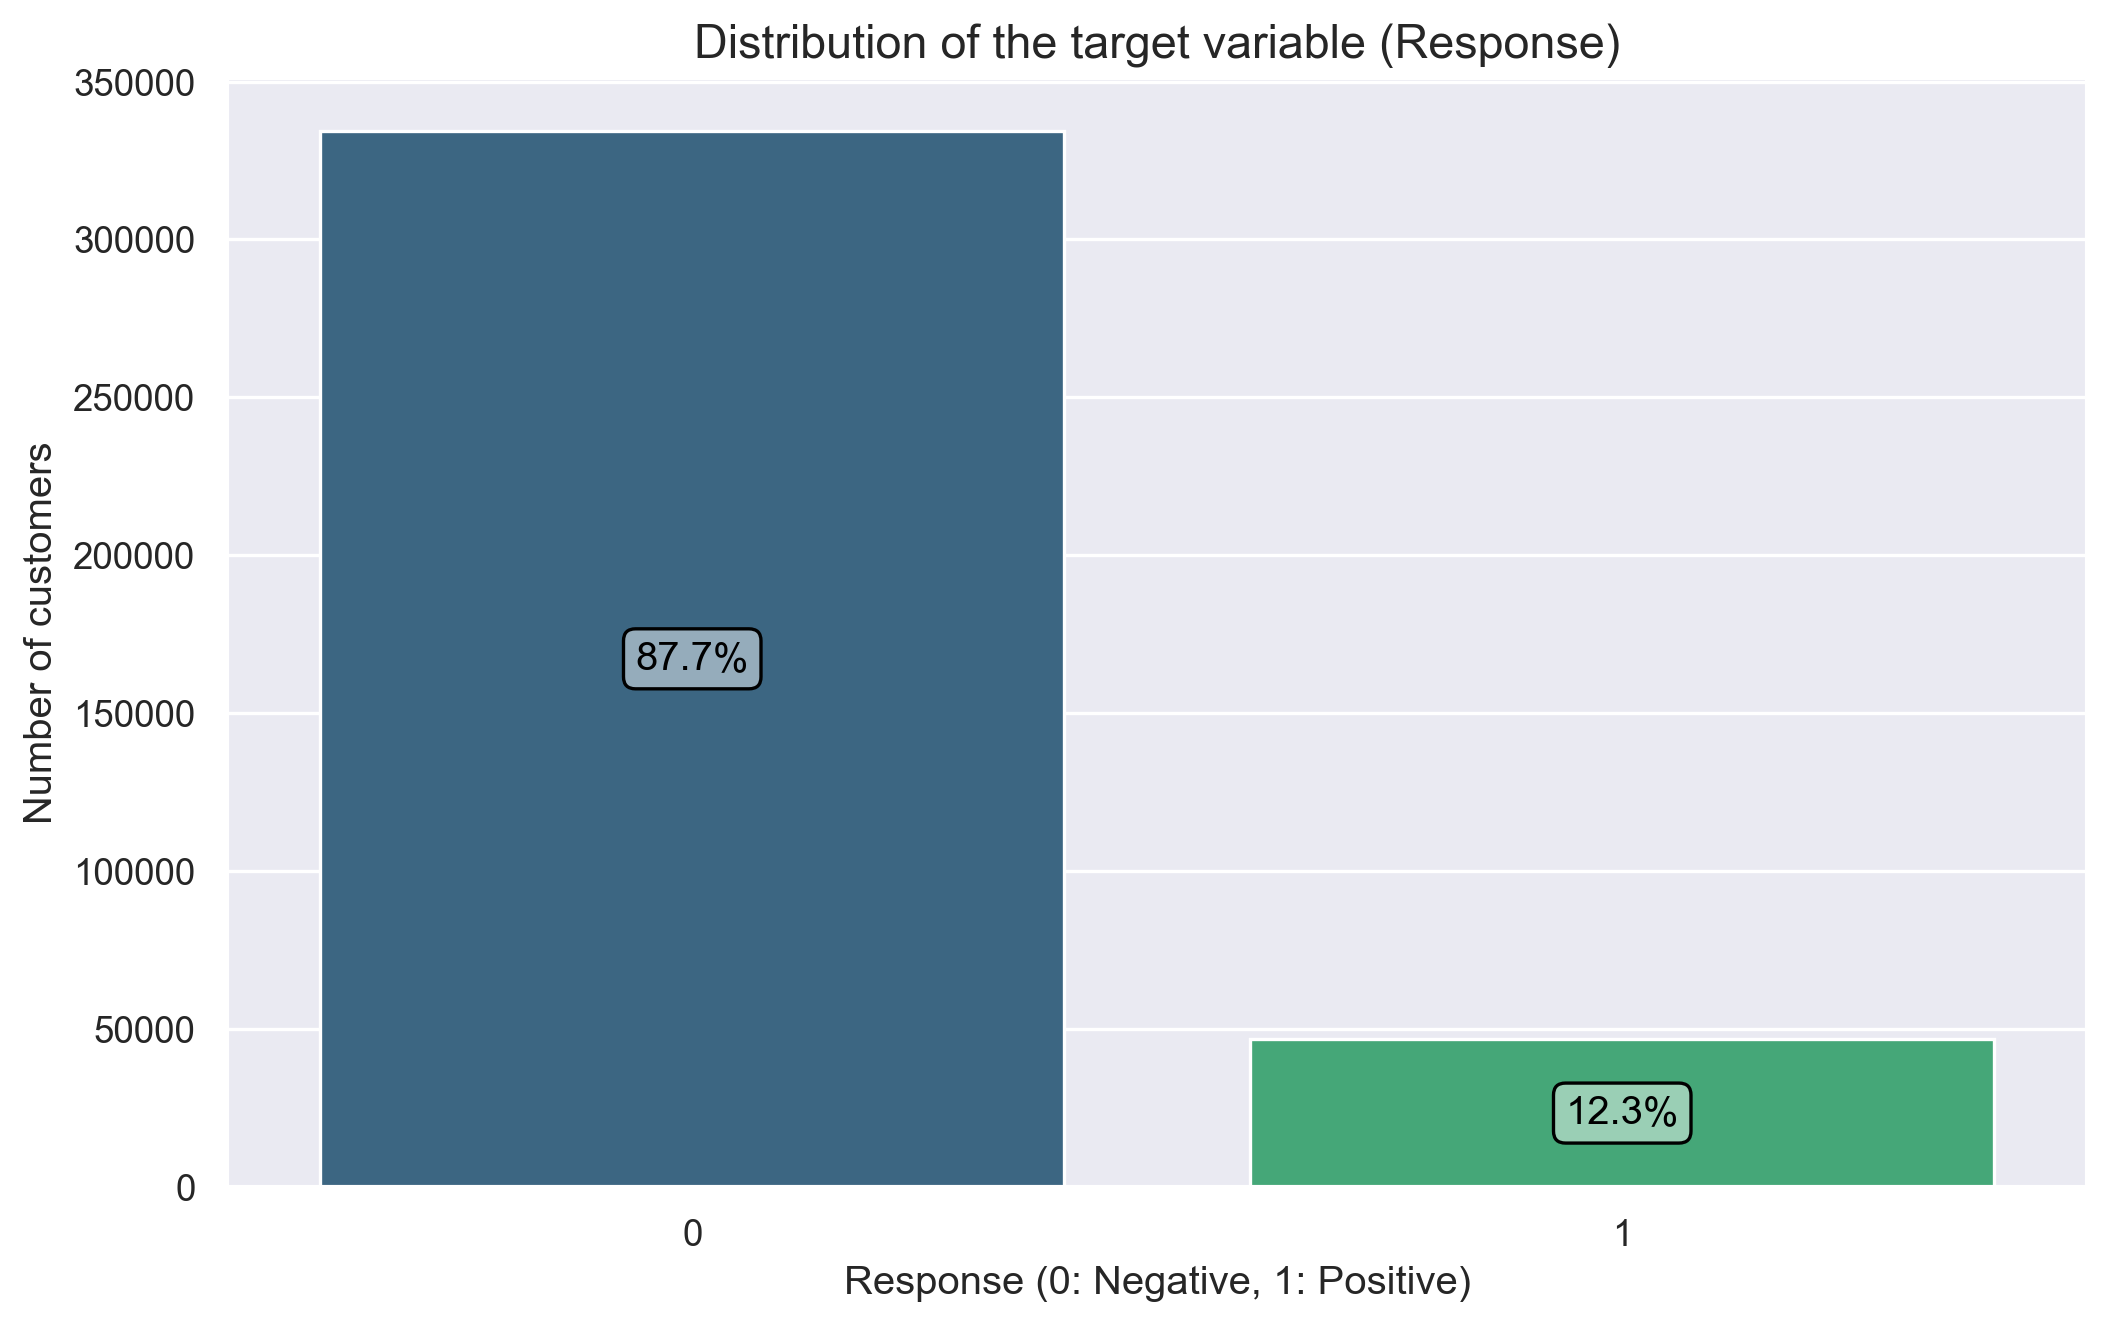

In [ ]:
# Count plot of the 'Response' variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Response', data=df, hue="Response", palette='viridis', legend=False)
plt.title('Distribution of the target variable (Response)', fontsize=14)
plt.xlabel('Response (0: Negative, 1: Positive)', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.annotate(f"{response_percentage[0]:.1f}%", 
             xy=(0, response_count[0]/2), 
             ha='center', va='center', 
             fontsize=12, color='black',
             bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))
plt.annotate(f"{response_percentage[1]:.1f}%", 
             xy=(1, response_count[1]/2), 
             ha='center', va='center', 
             fontsize=12, color='black',
             bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))
plt.show()

It can be observed that the distribution of the 'Response' variable is strongly inbalanced, with 87.7% of customers giving a negative response.

### Exploration of categorical variables

In [39]:
# Mapping of Vehicle_Damage variable
mapping = {"< 1 Year": "0: < 1 Year", "1-2 Year": "1: 1-2 Year", "> 2 Years": "2: > 2 Years"}
df["Vehicle_Age"] = df["Vehicle_Age"].map(mapping)

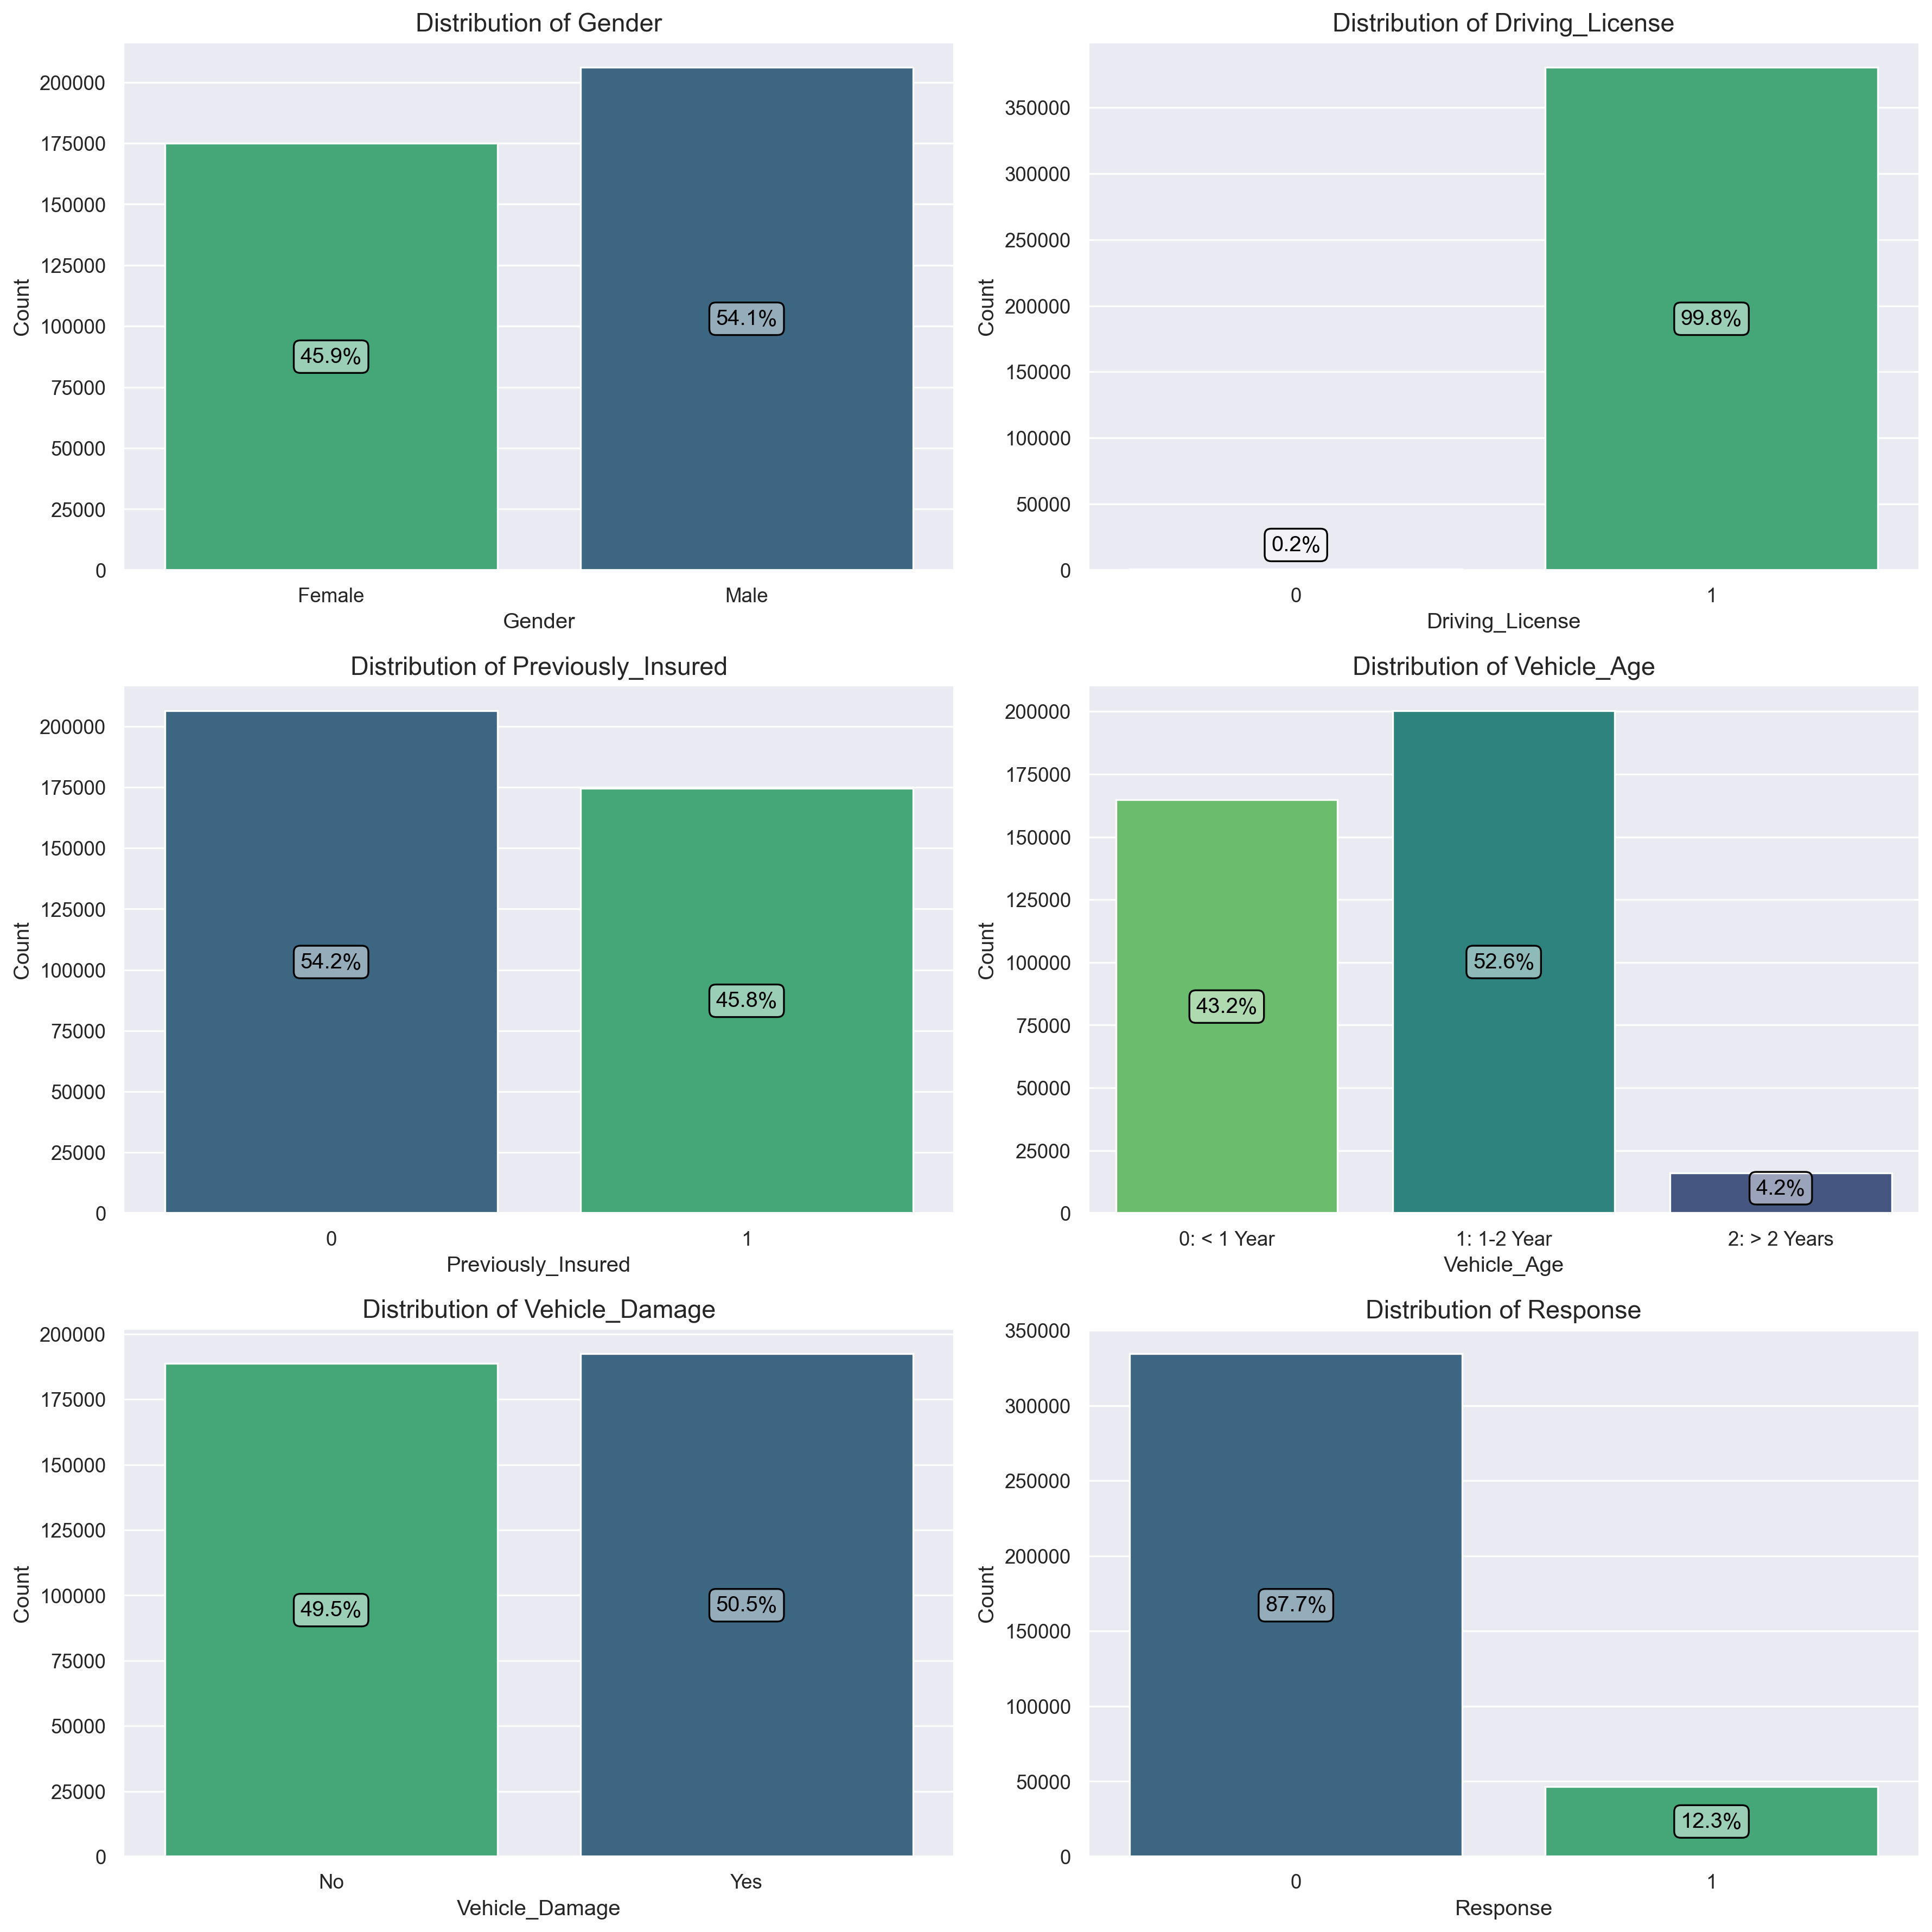

In [40]:
cat_columns = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

# Count plots of the categorial variables

plt.figure(figsize=(15, 15))

for i, column in enumerate(cat_columns):
       
    # Counts and percentages for each category
    counts = df[column].value_counts().sort_index()
    percentages = df[column].value_counts(normalize=True).sort_index() * 100
    
    # Plots of general distribution
    plt.subplot(3, 2, i+1)
    sns.countplot(x=column, hue=column, data=df, order=df[column].value_counts().sort_index().index, palette='viridis', legend=False)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)

    for j, (value, count) in enumerate(counts.items()):
        plt.annotate(f"{percentages.iloc[j]:.1f}%", 
                 xy=(j, max(counts.iloc[j]/2, max(counts)*.05)), 
                 ha='center', va='center', 
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))
    
plt.tight_layout()
plt.show()

### Exploration of numerical variables

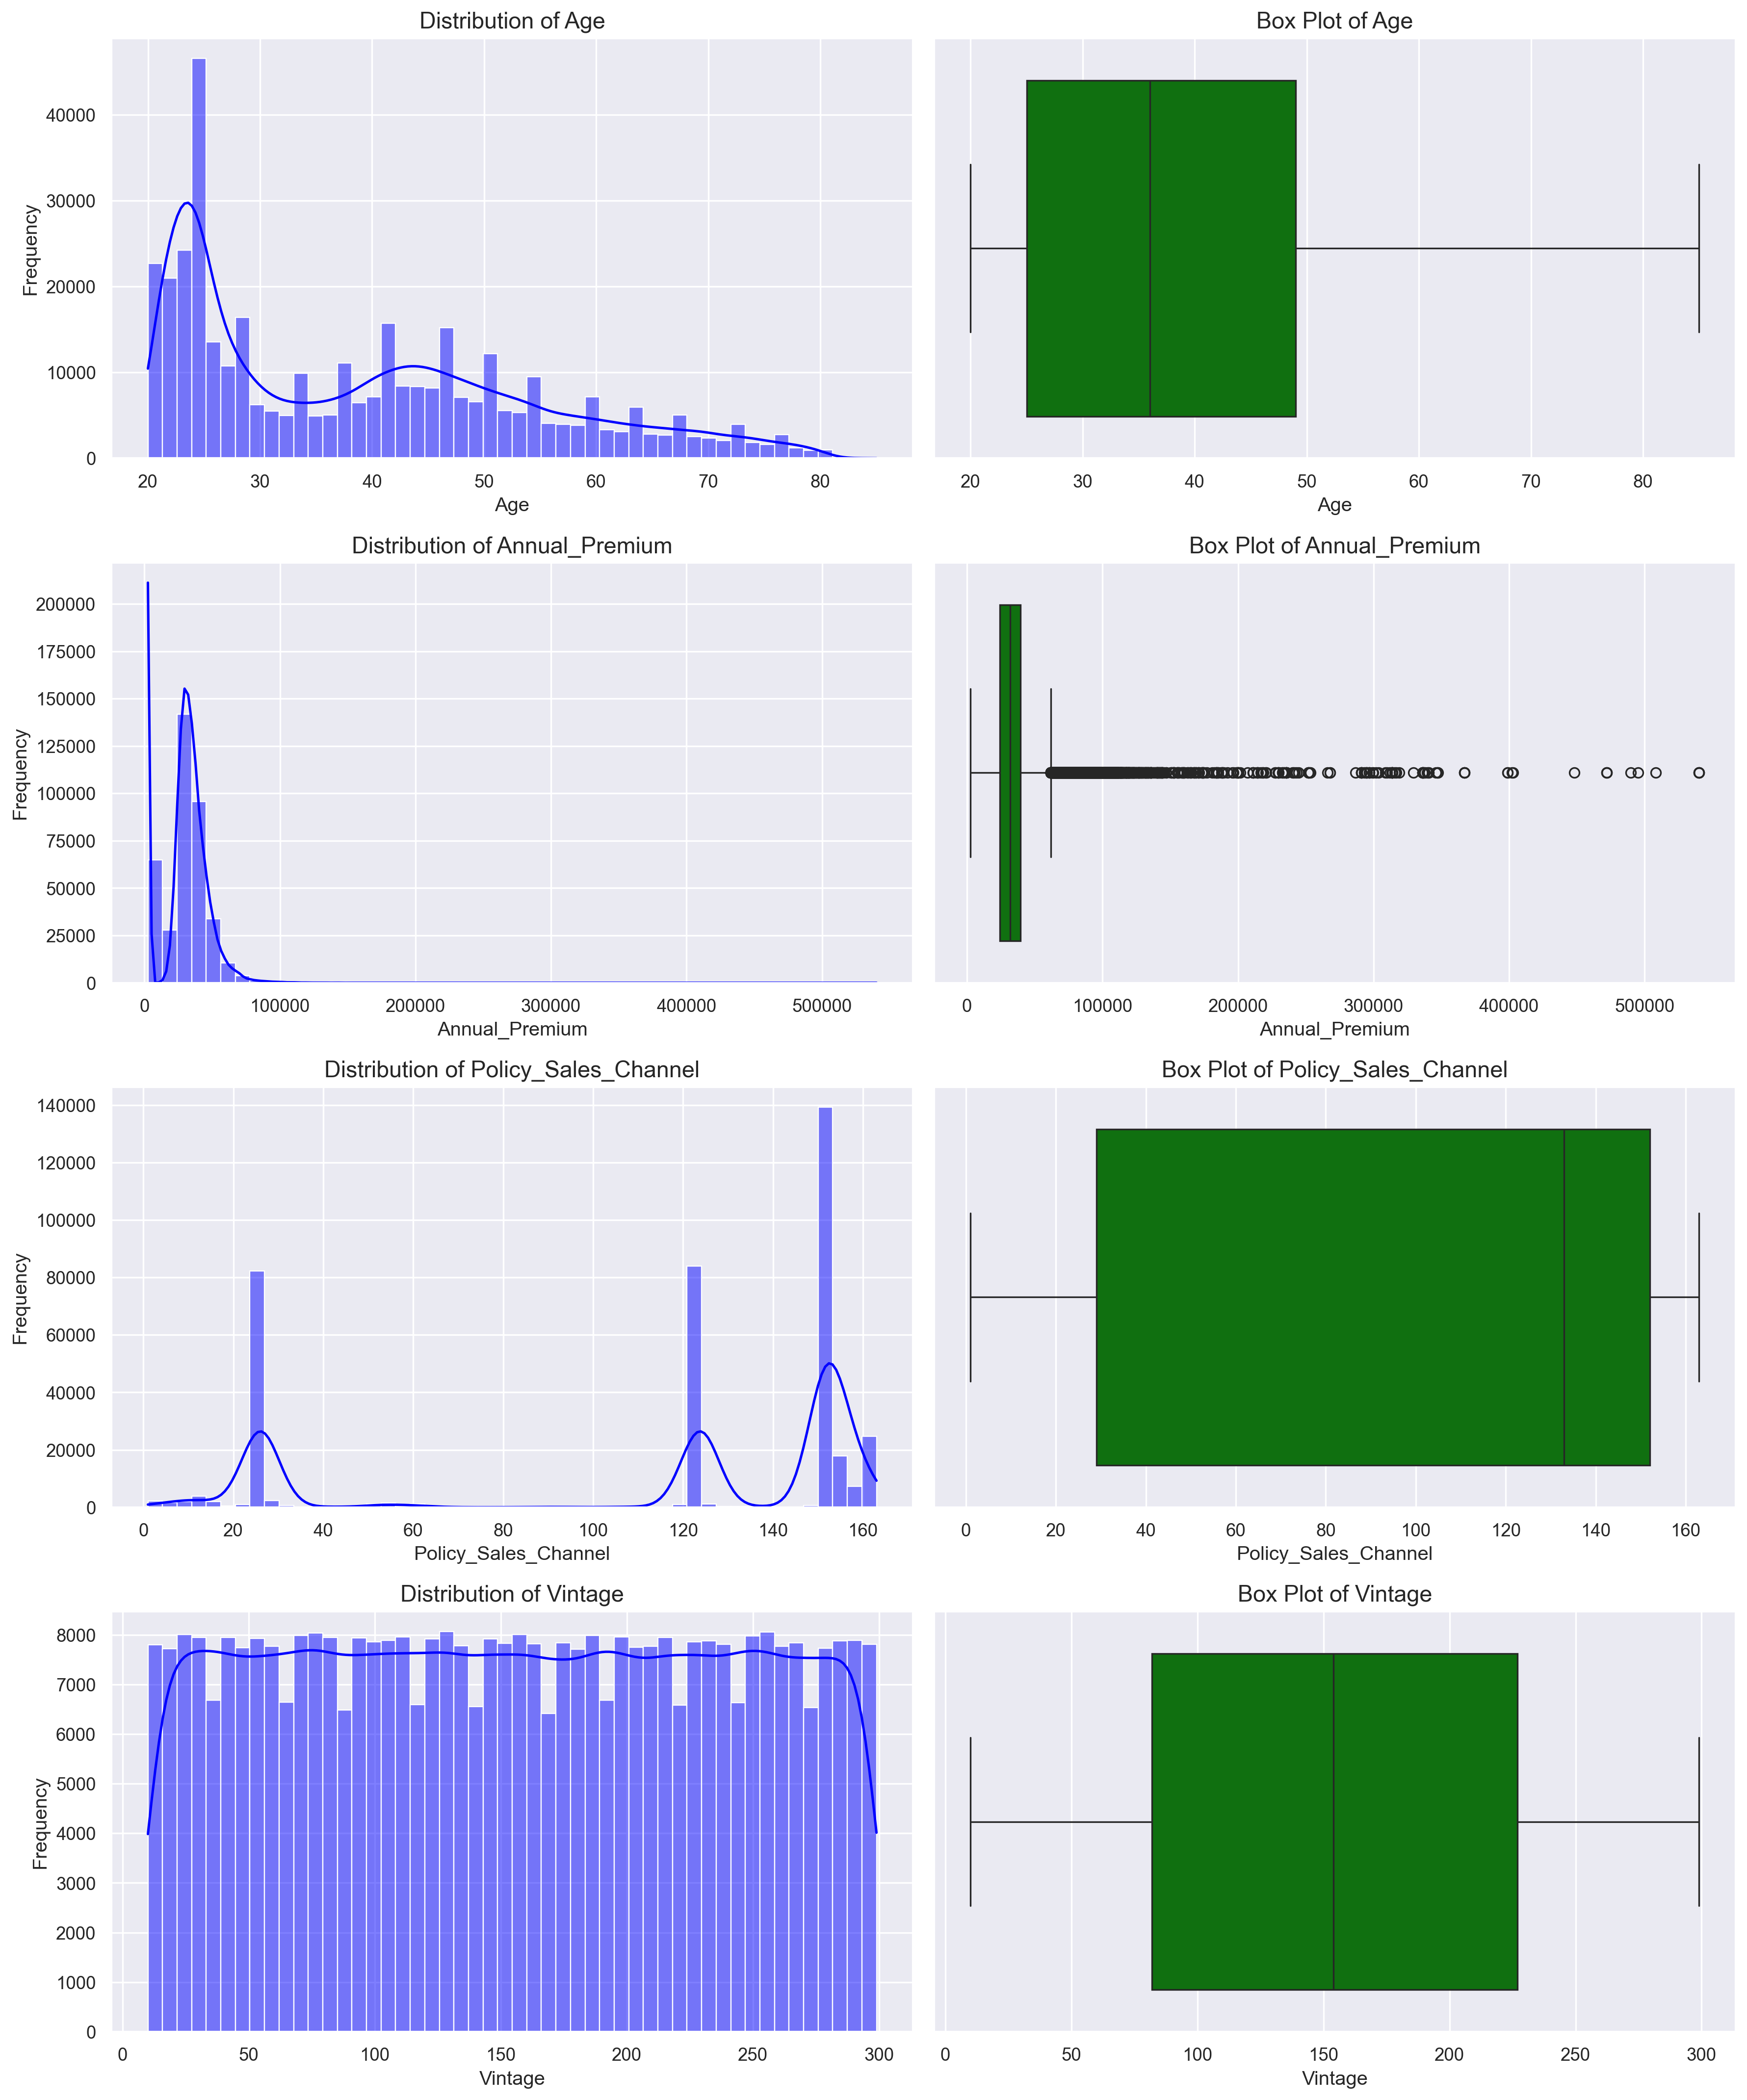

In [41]:
num_columns = ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# Plots of the numerical variables

plt.figure(figsize=(15, 18))

for i, column in enumerate(num_columns):
    
    # Distributions
    plt.subplot(4, 2, (2*i)+1)
    sns.histplot(df[column], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Box plots
    plt.subplot(4, 2, (2*i)+2)
    sns.boxplot(x=df[column], color='green')
    plt.title(f'Box Plot of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    
plt.tight_layout()
plt.show()

By observing the plots, it can be more appropriate, for the building of the predictive model, to consider the 'Policy_Sales_Channel' variable as a categorical variable with 155 categories.

In [42]:
n_policy_sales_channels = len(df.Policy_Sales_Channel.unique())
print(f"Number of categories ('Policy_Sales_Channel'): {n_policy_sales_channels}")

Number of categories ('Policy_Sales_Channel'): 155


### Focus on key variables

Here, the relation between some key variables ('Age', 'Annual Premium', 'Vehicle Age', 'Previously Insured') and the target variable 'Response' is analysed.

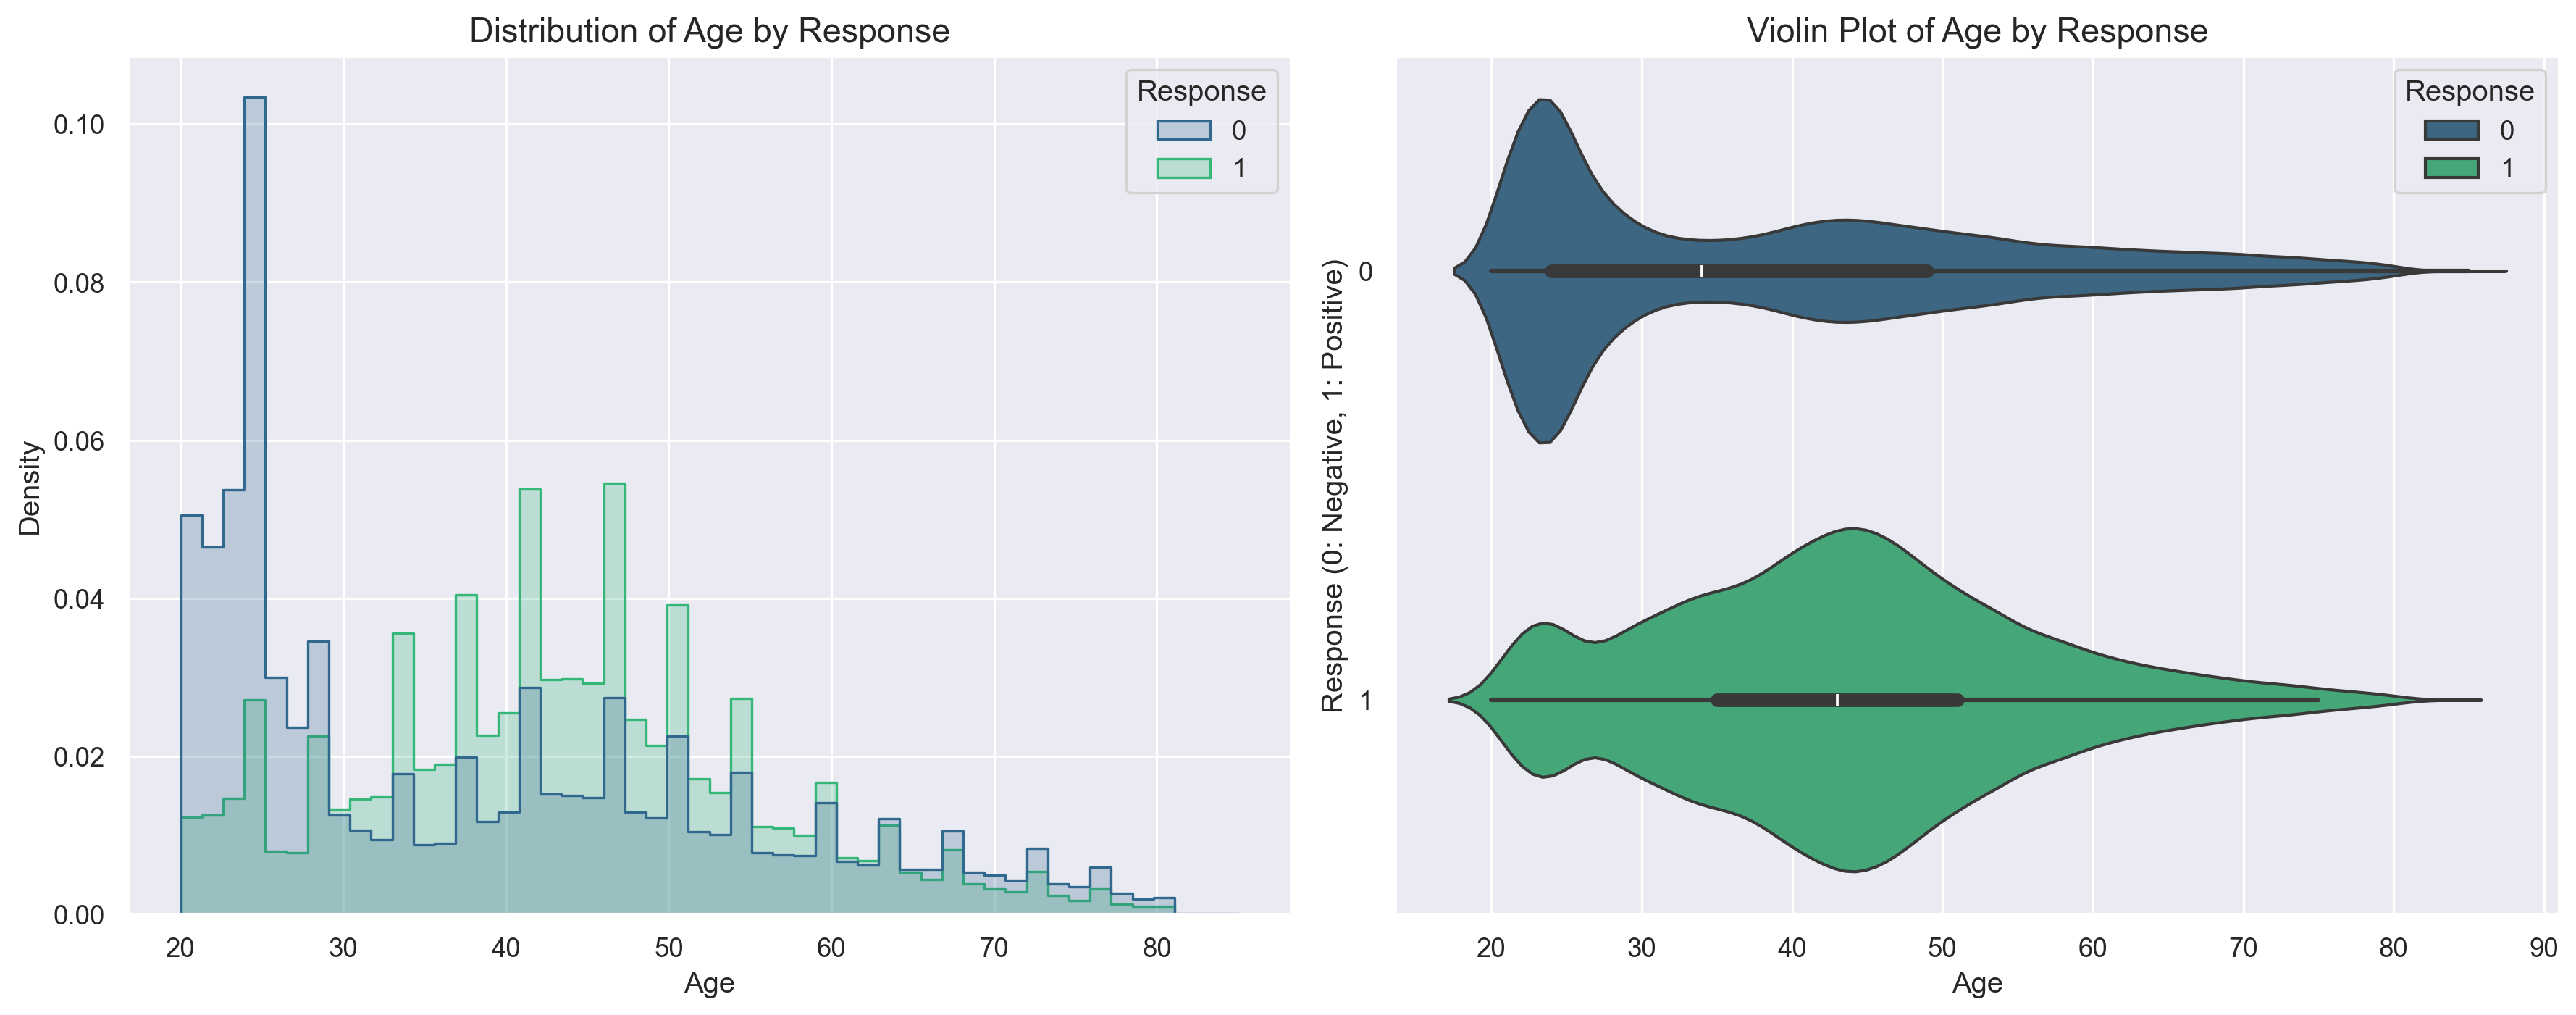

In [43]:
# Age and Response

plt.figure(figsize=(15, 6))
bins = 50

# Density of Age by Response
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Response', element='step', 
             stat='density', common_norm=False, bins=bins, palette='viridis')
plt.title('Distribution of Age by Response', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Violin plot of Age by Response
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Age', y='Response', orient="y", 
               hue="Response", palette='viridis')
plt.title(f'Violin Plot of Age by Response', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Response (0: Negative, 1: Positive)', fontsize=12)

plt.tight_layout()
plt.show()

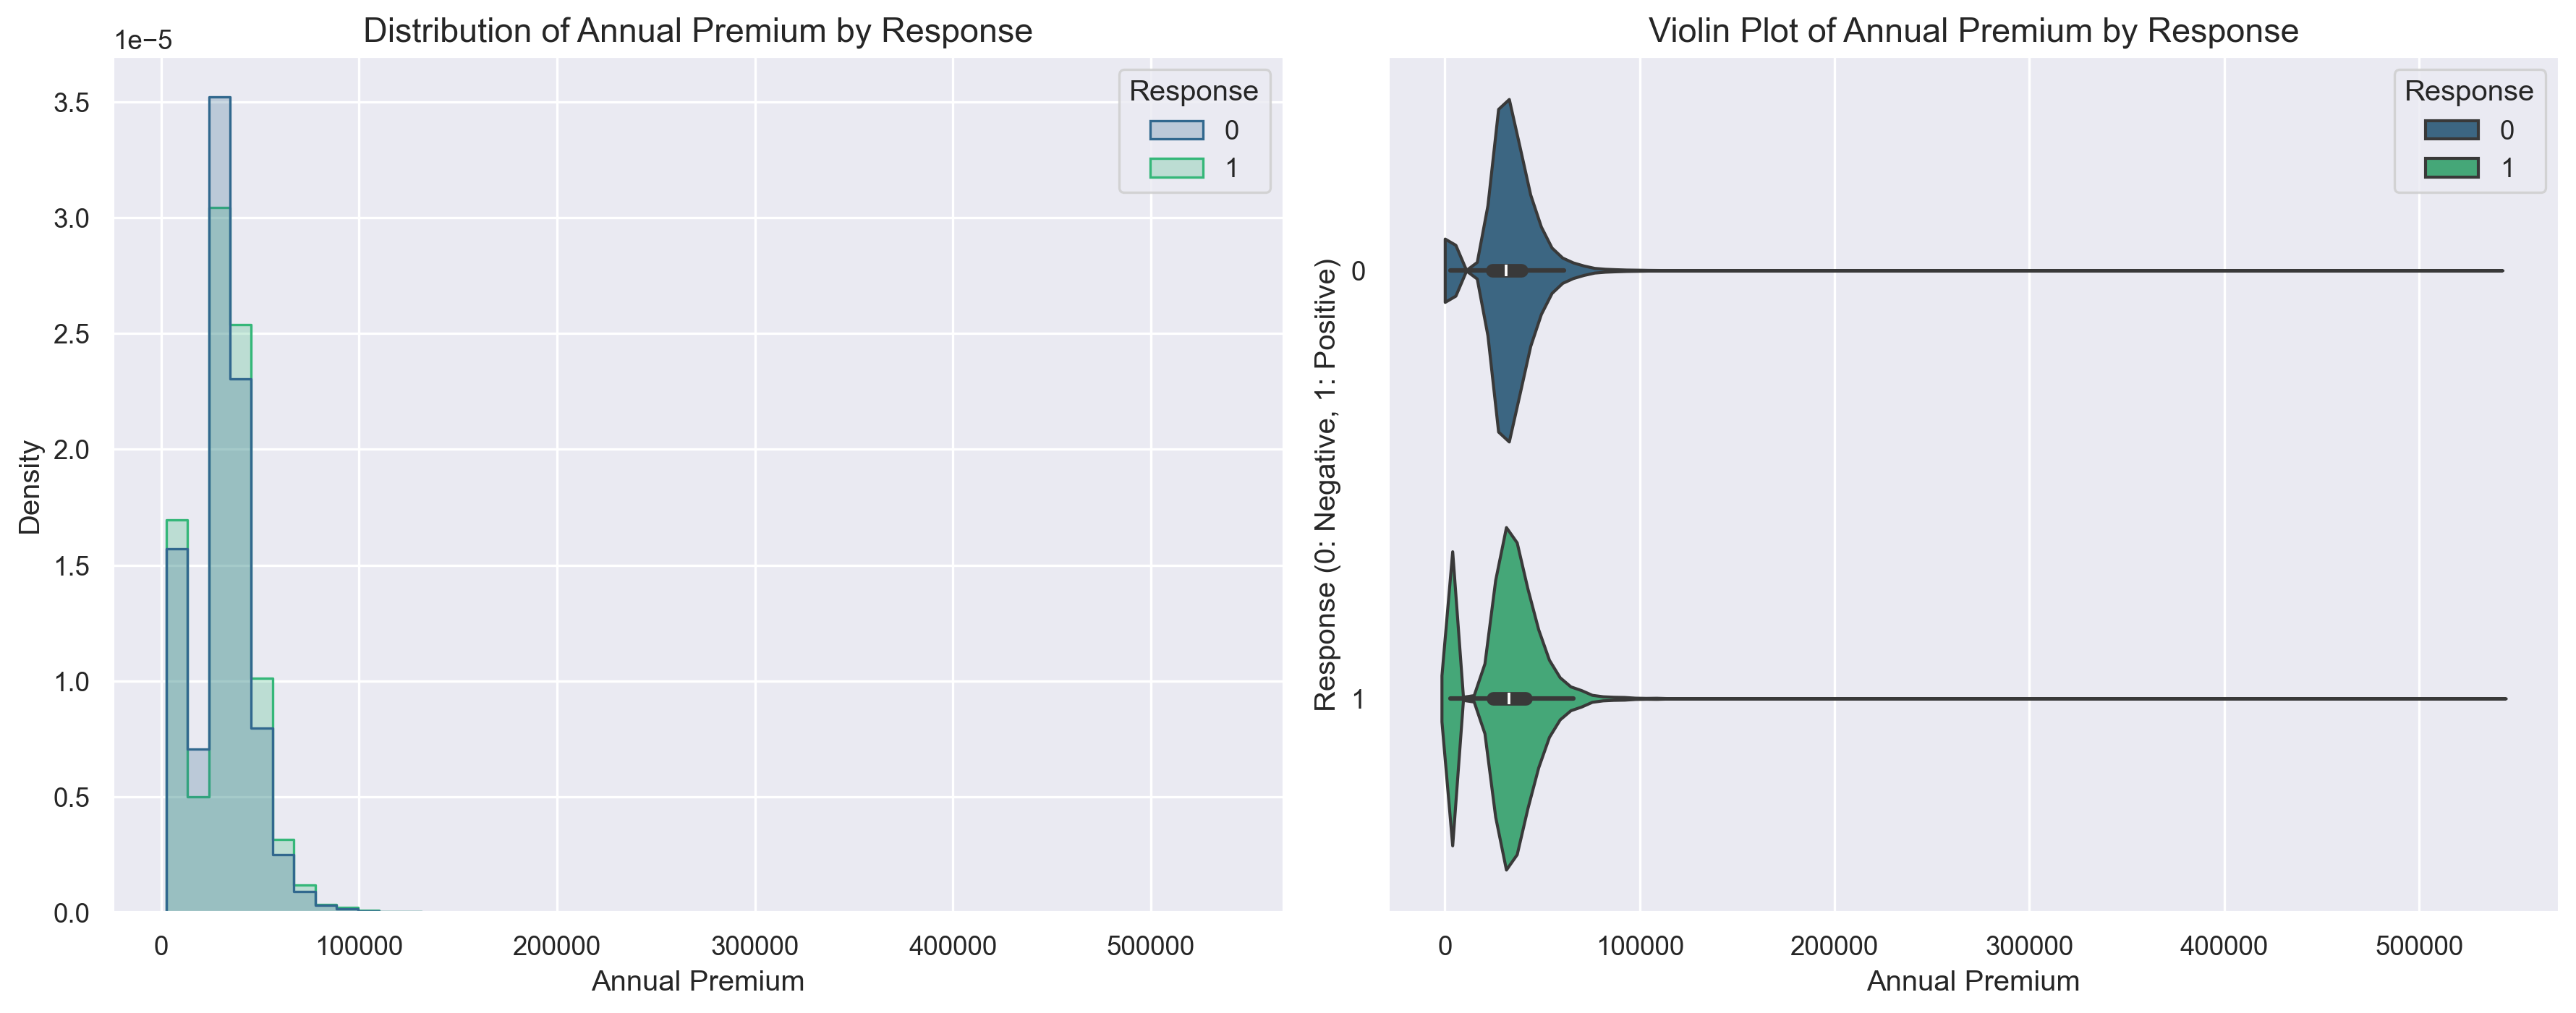

In [44]:
# Annual Premium and Resposne

plt.figure(figsize=(15, 6))
bins = 50

# Density of Annual_Premium by Response
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Annual_Premium', hue='Response', element='step', 
             stat='density', common_norm=False, bins=bins, palette='viridis', 
             #log_scale=True
             )
plt.title('Distribution of Annual Premium by Response', fontsize=14)
plt.xlabel('Annual Premium', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Violin plot of Annual_Premium by Response
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Annual_Premium', y='Response', orient="y", 
               hue="Response", palette='viridis', 
               #log_scale=True
               )
plt.title(f'Violin Plot of Annual Premium by Response', fontsize=14)
plt.xlabel('Annual Premium', fontsize=12)
plt.ylabel('Response (0: Negative, 1: Positive)', fontsize=12)

plt.tight_layout()
plt.show()

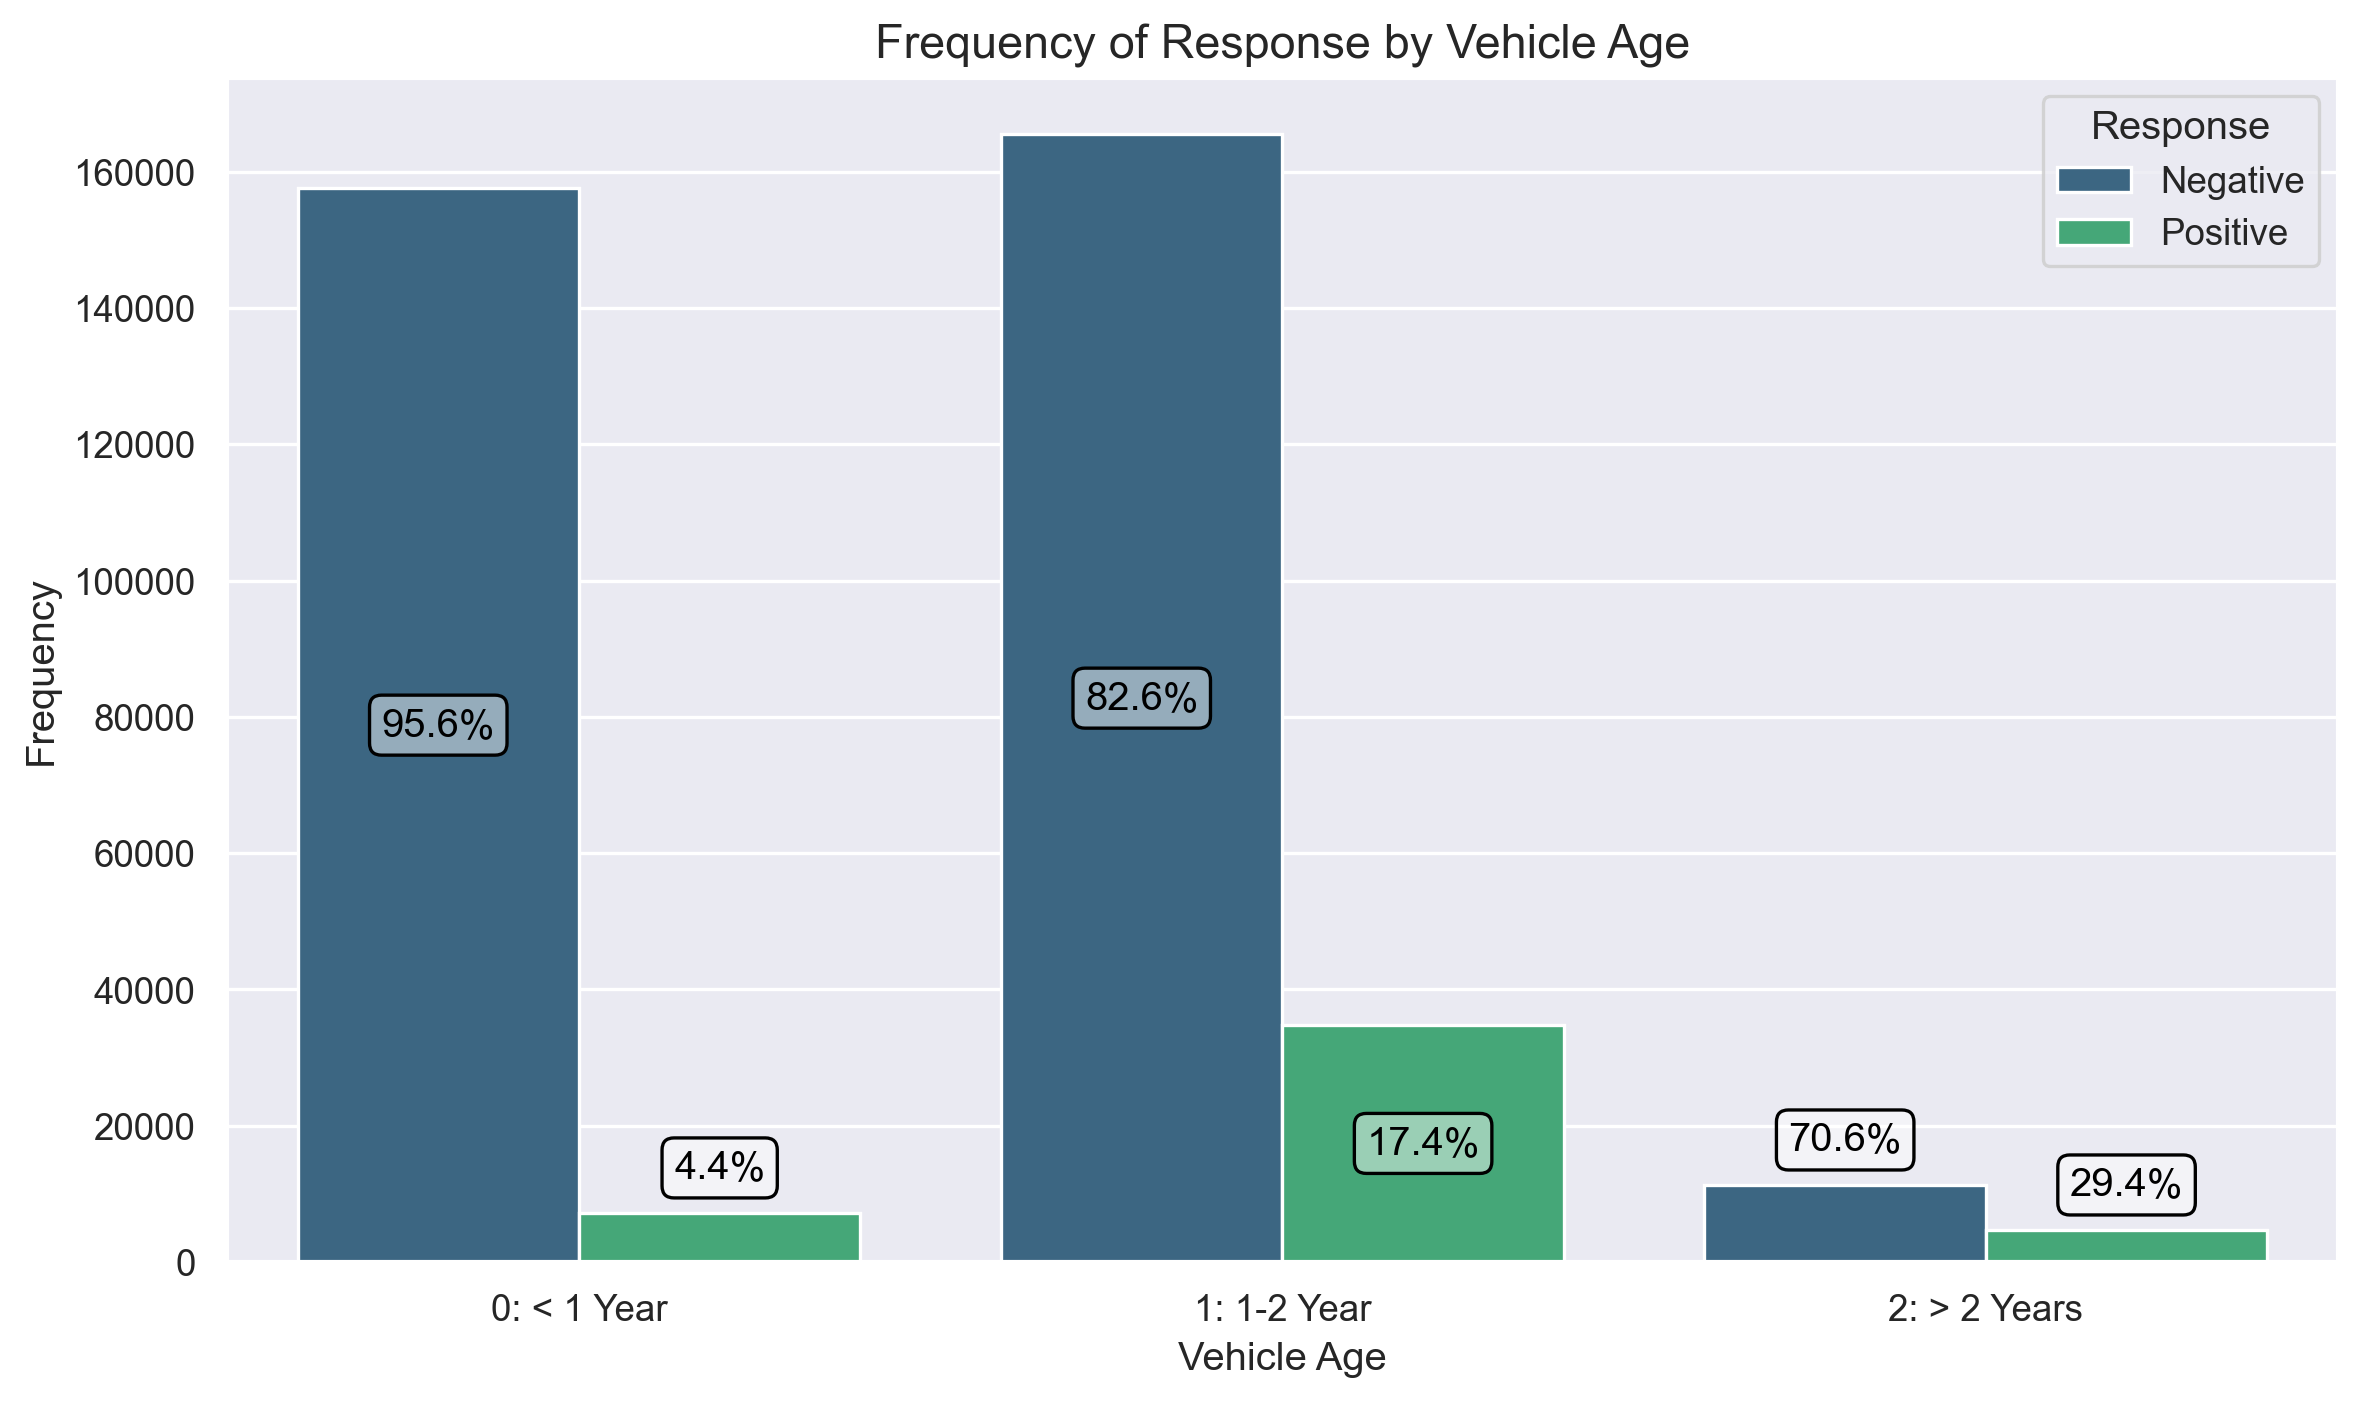

In [45]:
# Vehicle Age and Response

plt.figure(figsize=(10, 6))

vehicle_age_response_freq = pd.crosstab(df['Vehicle_Age'], df['Response'])
vehicle_age_response_perc = pd.crosstab(df['Vehicle_Age'], df['Response'], normalize='index') * 100

# Count plot of Vehicle Age by Response
ax = sns.countplot(x="Vehicle_Age", hue="Response", data=df, order=df["Vehicle_Age"].value_counts().sort_index().index, palette="viridis")

plt.title('Frequency of Response by Vehicle Age', fontsize=14)
plt.xlabel('Vehicle Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Response', labels=['Negative', 'Positive'])
plt.xticks(rotation=0)

for i, vehicle_age in enumerate(vehicle_age_response_freq.index):
    for j, response in enumerate(vehicle_age_response_freq.columns):
        count = vehicle_age_response_freq.loc[vehicle_age, response]
        percentage = vehicle_age_response_perc.loc[vehicle_age, response]
               
        bar = ax.containers[j][i] # Get the position of each bar
        
        y_pos = count/2 if count/2 > np.amax(vehicle_age_response_freq)*.1 else bar.get_height()
        y_offset = 0 if count/2 > np.amax(vehicle_age_response_freq)*.1 else 45
        ax.annotate(f'{percentage:.1f}%', 
                   xy=(bar.get_x() + bar.get_width()/2, y_pos),
                   xytext=(0, y_offset),
                   textcoords="offset pixels",
                   ha='center', va='center',
                   color='black',
                   bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.tight_layout()
plt.show()

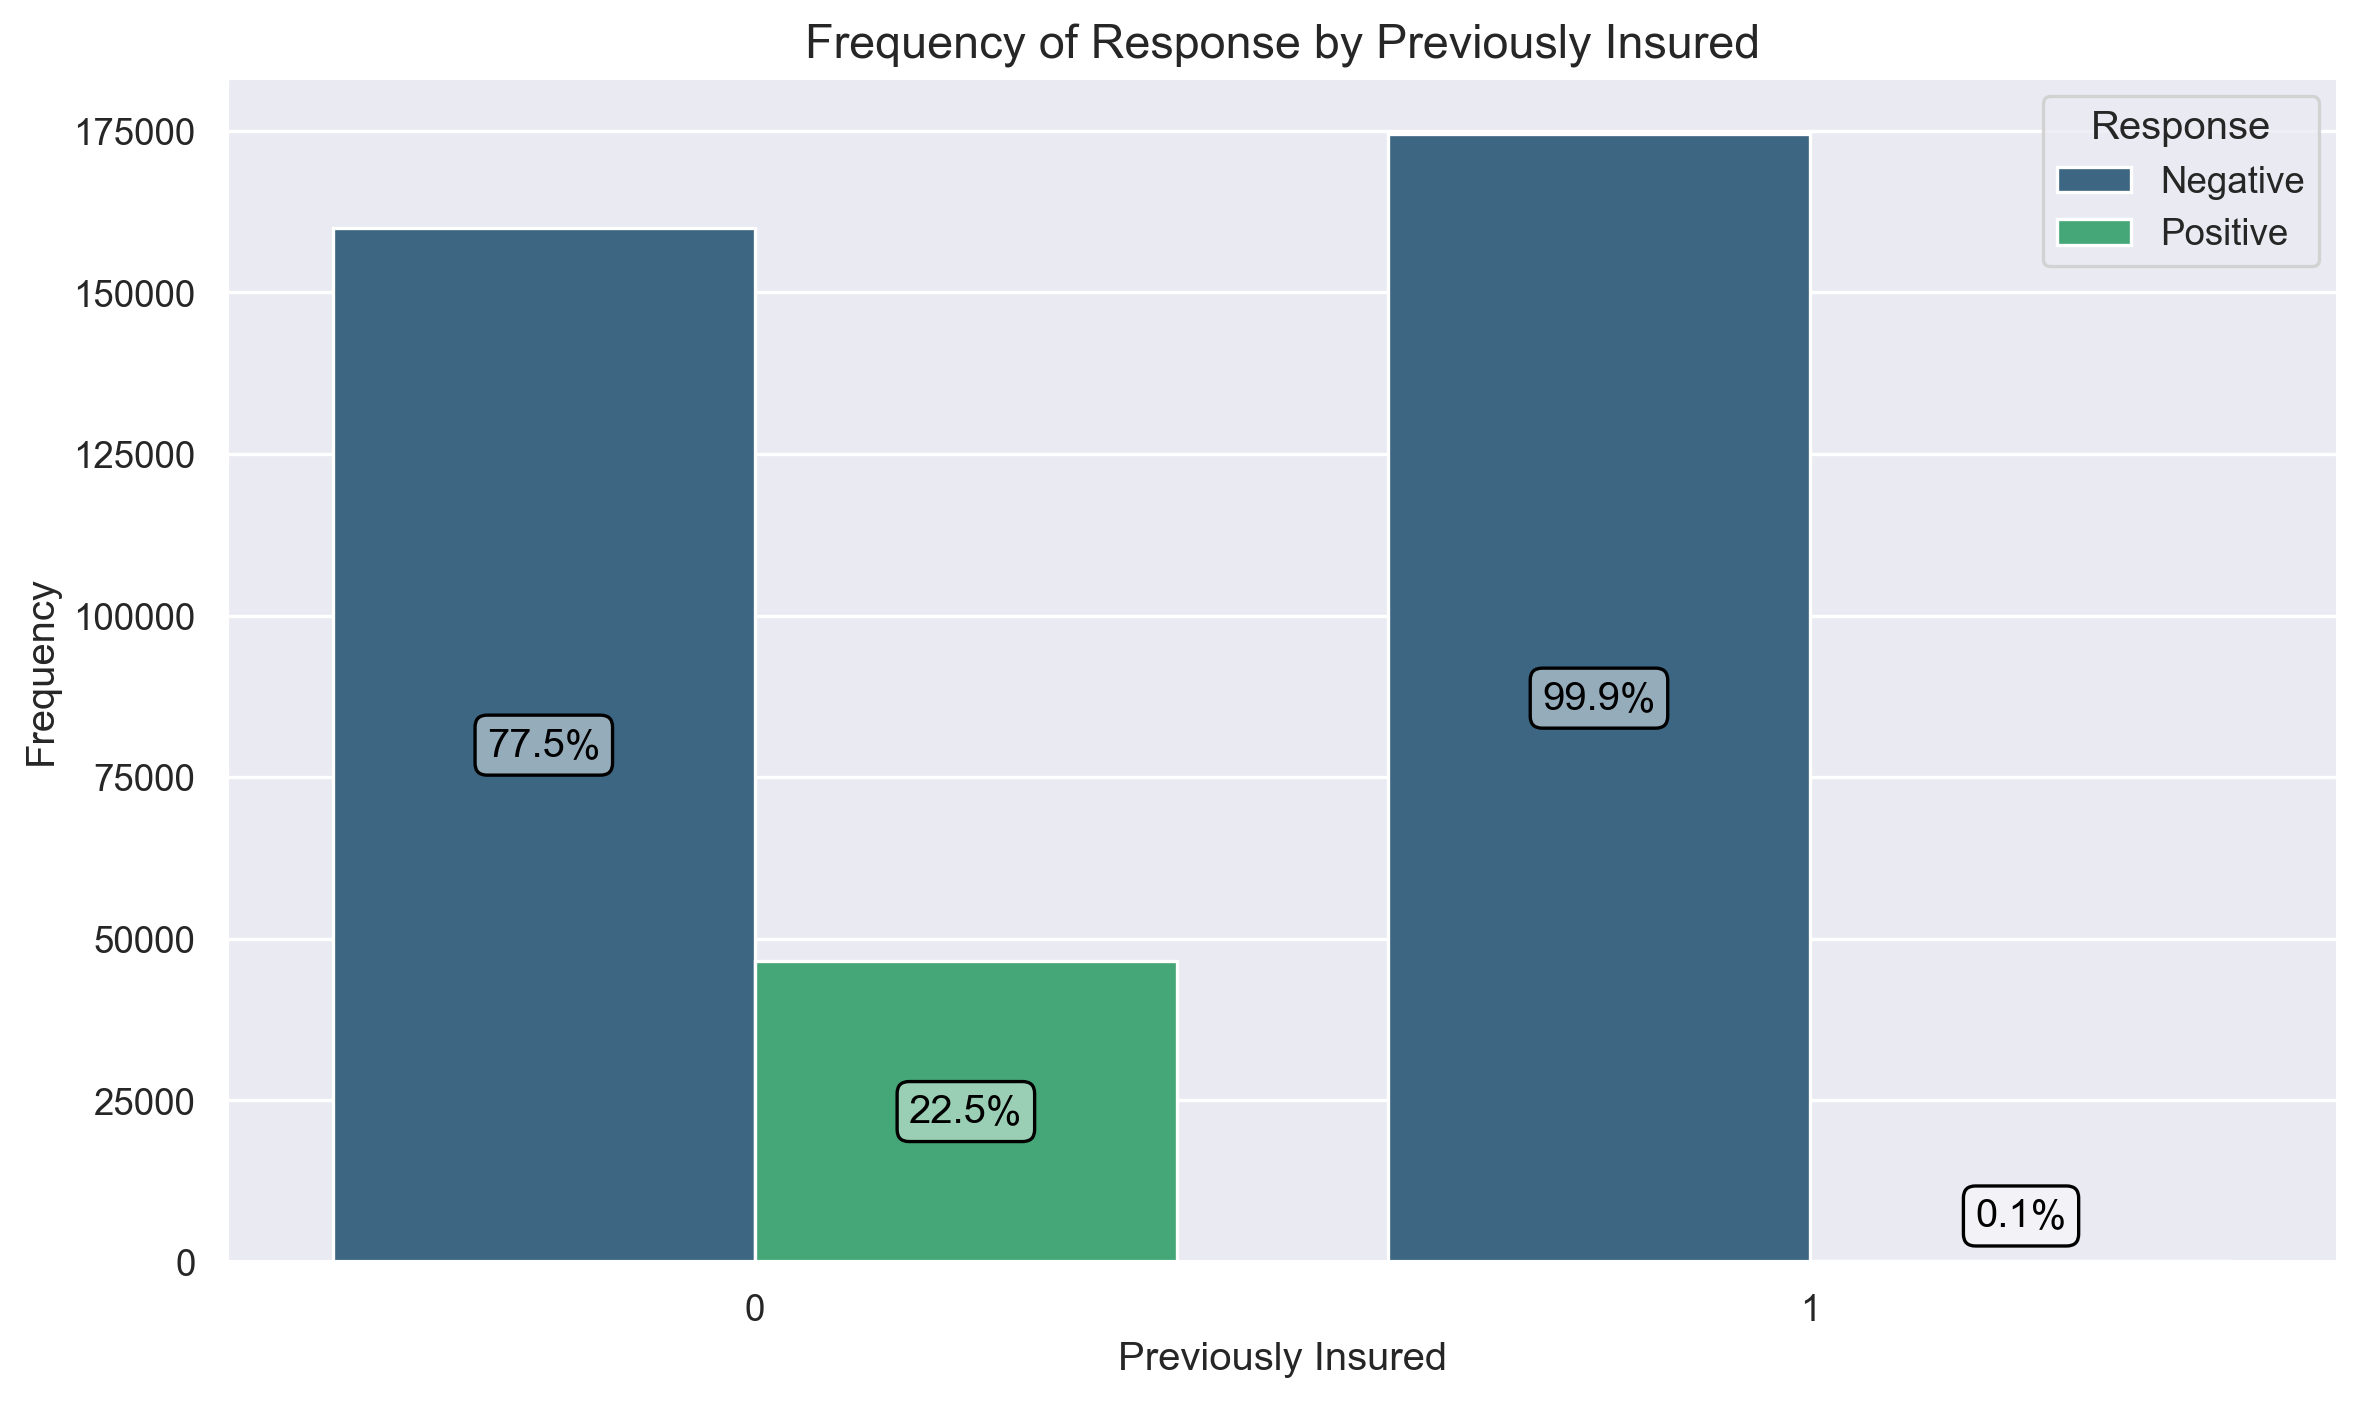

In [46]:
# Previously Insured and Response

plt.figure(figsize=(10, 6))

previously_insured_response_freq = pd.crosstab(df['Previously_Insured'], df['Response'])
previously_insured_response_perc = pd.crosstab(df['Previously_Insured'], df['Response'], normalize='index') * 100

# Count plot of Previously Insured by Response
ax = sns.countplot(x="Previously_Insured", hue="Response", data=df, order=df["Previously_Insured"].value_counts().sort_index().index, palette="viridis")

plt.title('Frequency of Response by Previously Insured', fontsize=14)
plt.xlabel('Previously Insured', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Response', labels=['Negative', 'Positive'])
plt.xticks(rotation=0)

for i, vehicle_age in enumerate(previously_insured_response_freq.index):
    for j, response in enumerate(previously_insured_response_freq.columns):
        count = previously_insured_response_freq.loc[vehicle_age, response]
        percentage = previously_insured_response_perc.loc[vehicle_age, response]
               
        bar = ax.containers[j][i] # Get the position of each bar
        
        y_pos = count/2 if count/2 > np.amax(previously_insured_response_freq)*.1 else bar.get_height()
        y_offset = 0 if count/2 > np.amax(previously_insured_response_freq)*.1 else 45
        ax.annotate(f'{percentage:.1f}%', 
                   xy=(bar.get_x() + bar.get_width()/2, y_pos),
                   xytext=(0, y_offset),
                   textcoords="offset pixels",
                   ha='center', va='center',
                   color='black',
                   bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.tight_layout()
plt.show()

From this analysis, some patterns can be observed:
- The frequency of negative response is higher in customers with age <30, while he frequency of positive response is higher in customers with age between 30 and 60
- The frequency of positive response is lower in customers with vehicles age <1 year
- The frequency of positive response is higher in customers wthout previously insured vehicles

### Correlation matrix

Here, the correlation between all the variables is explored.

First, the  categorical variables must be converted to numeric.

In [49]:
# Categorical variables
obj_columns = df.select_dtypes(include=[object]).columns
obj_columns

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [51]:
# Categories
for column in obj_columns:
    print(column)
    print(f"Categories: {df[column].unique()}\n")

Gender
Categories: ['Male' 'Female']

Vehicle_Age
Categories: ['2: > 2 Years' '1: 1-2 Year' '0: < 1 Year']

Vehicle_Damage
Categories: ['Yes' 'No']



In [ ]:
# Encoding of categorial variables
df["Gender"] = df["Gender"].map({"Male":0, "Female":1})
df["Vehicle_Age"] = df["Vehicle_Age"].map({"0: < 1 Year":0, "1: 1-2 Year":1, "2: > 2 Years":2})
df["Vehicle_Damage"] = df["Vehicle_Damage"].map({"No":0, "Yes":1})

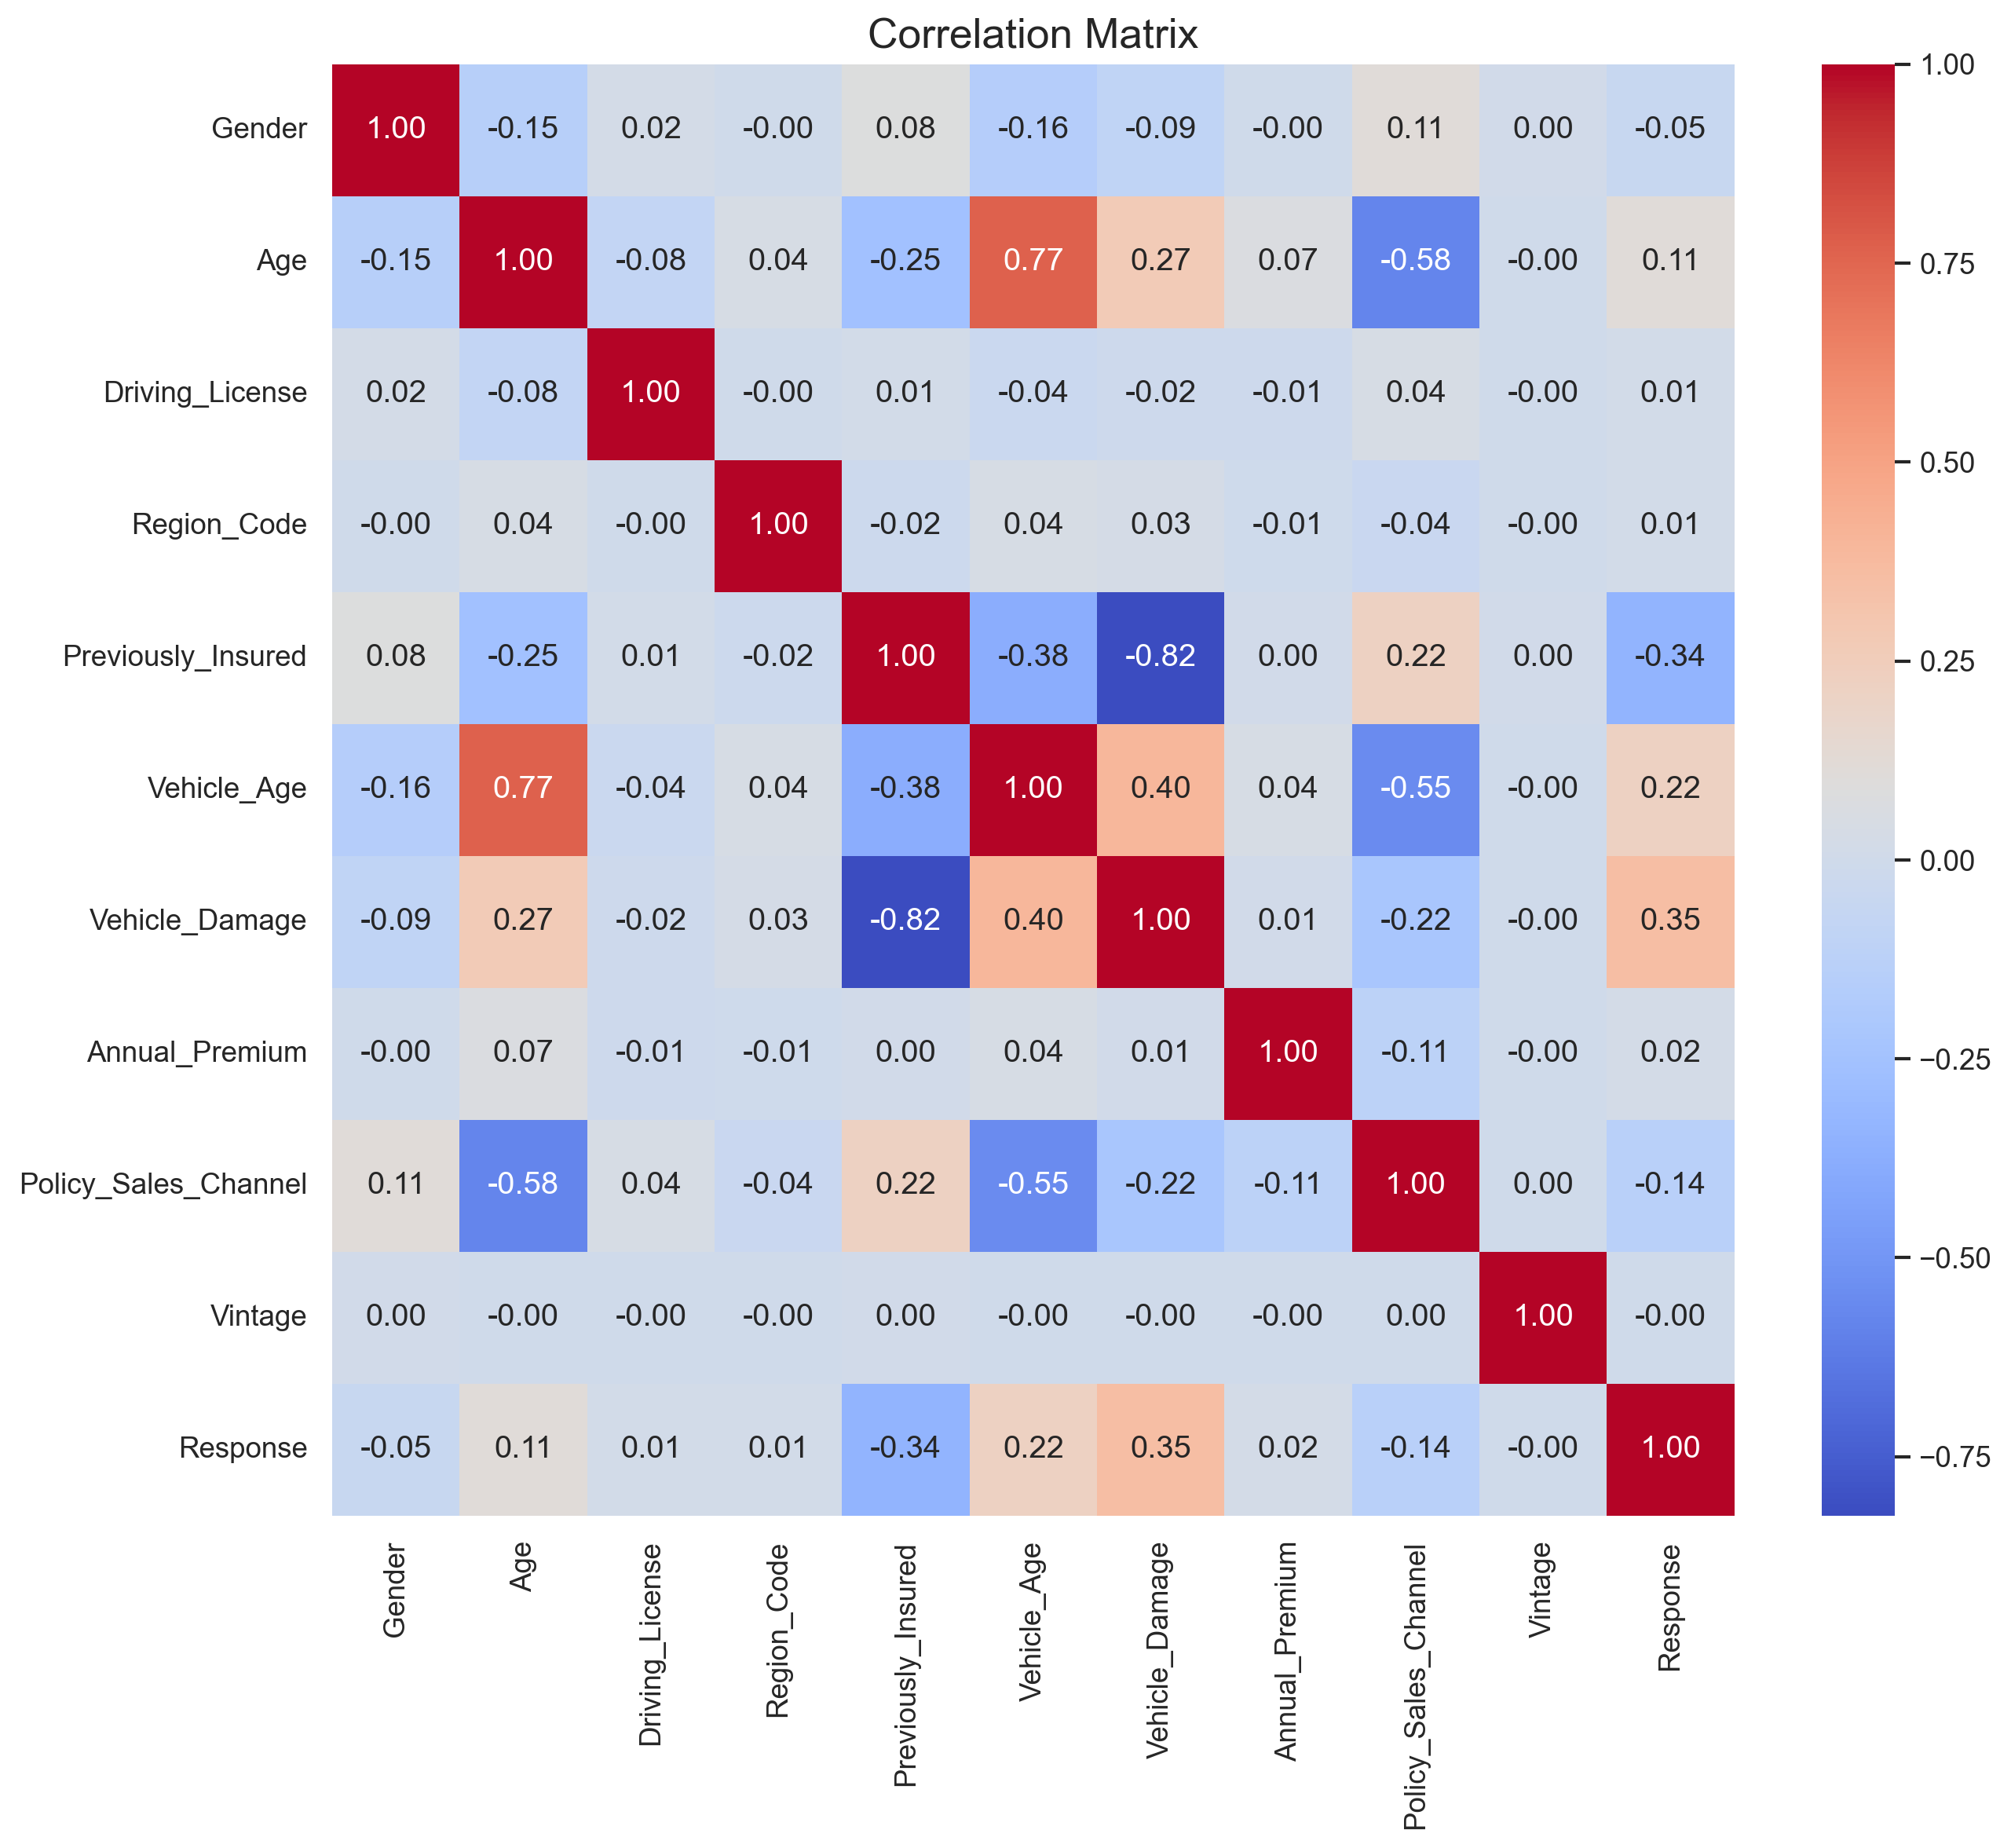

In [53]:
# Correlation matrix

df_corr = df.iloc[:,1:].copy()

corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [54]:
print("Correlations with Response:")
print(corr_matrix['Response'].sort_values(ascending=False))

Correlations with Response:
Response                1.000000
Vehicle_Damage          0.354400
Vehicle_Age             0.221874
Age                     0.111147
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
Gender                 -0.052440
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
Name: Response, dtype: float64


Based on this exploratory analysis, some of the features are likely to be not particularly informative (e.g. 'Driving_License', 'Region_Code', 'Vintage'), but will be included in the dataset for the building of the preditive model.

### Other box plots by category

Here, some box plots are created, to visualize the relation betwwen the numerical variable 'Age', some informative categorical variables ('Vehicle_Damage', 'Vehicle_Age', 'Previously_Insured') and the target variable 'Response'.

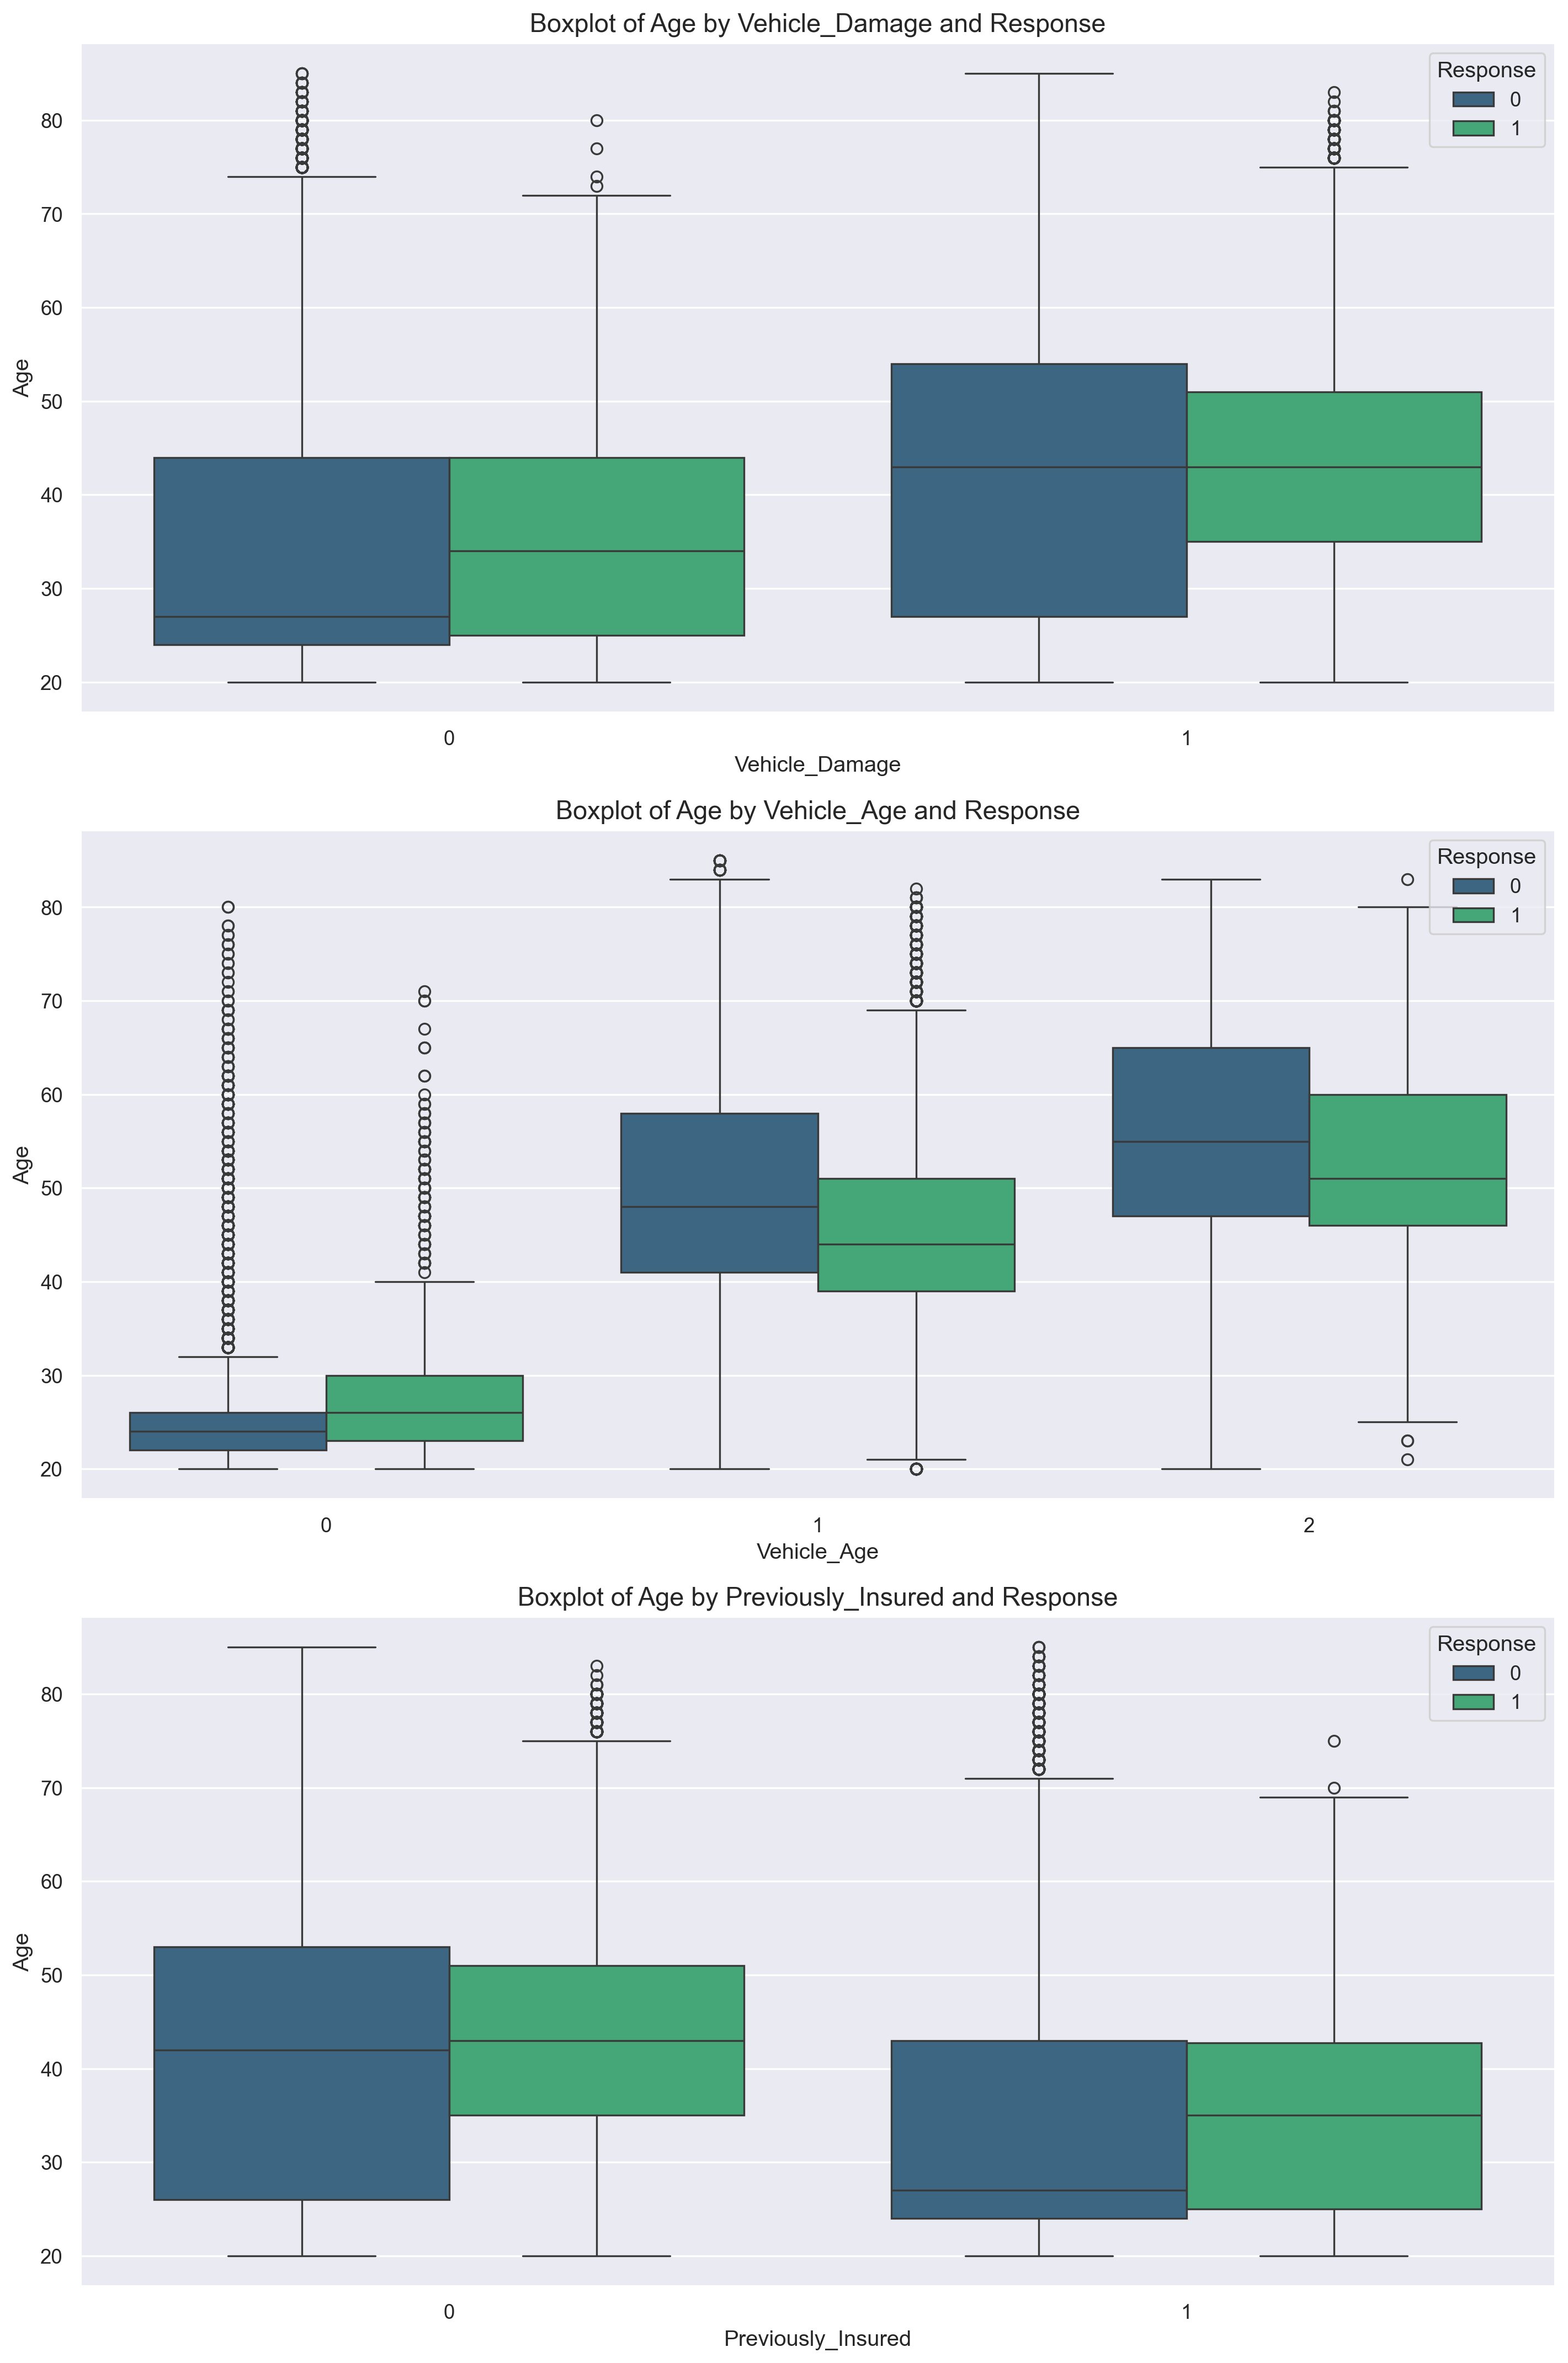

In [23]:
cat_columns = ["Vehicle_Damage", "Vehicle_Age", "Previously_Insured"]

plt.figure(figsize=(12, 18))

for i, column in enumerate(cat_columns):

    plt.subplot(3, 1, i+1)
    sns.boxplot(data=df, x=column, y='Age', hue="Response", palette='viridis')
    plt.title(f'Boxplot of Age by {column} and Response', fontsize=14)
    plt.legend(title='Response', loc='upper right')

    
plt.tight_layout()
plt.show()

## Addressing imbalanced classes

The target variable 'Response' resulted strongly unbalanced, with many more customers giving a negative response. This is known to cause  problems in the predictive models, in particular resulting in a high accuracy which is only reflecting the underlying class distribution. Therefore, some oversampling and undersampling methods will be used to create more balanced datasets and improve the model’s ability to generalize.

First, it will be applied a one-hot encoding on the multi-class categorial features.

In [25]:
# One-hot encoding on 'Region_Code', 'Vehicle_Age' and 'Policy_Sales_Channel' variables
df_2 = pd.get_dummies(df, columns=["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"], dtype=int)
df_2

id  Gender  Age  Driving_License  Previously_Insured  \
0            1       0   44                1                   0   
1            2       0   76                1                   0   
2            3       0   47                1                   0   
3            4       0   21                1                   1   
4            5       1   29                1                   1   
...        ...     ...  ...              ...                 ...   
381104  381105       0   74                1                   1   
381105  381106       0   30                1                   1   
381106  381107       0   21                1                   1   
381107  381108       1   68                1                   0   
381108  381109       0   46                1                   0   

        Vehicle_Damage  Annual_Premium  Vintage  Response  Region_Code_0.0  \
0                    1         40454.0      217         1                0   
1                    0         33536.0      183         0                0   
2                    1         38294.0       27         1                0   
3                    0         28619.0      203         0                0   
4                    0         27496.0       39         0                0   
...                ...             ...      ...       ...              ...   
381104               0         30170.0       88         0                0   
381105               0         40016.0      131         0                0   
381106               0         35118.0      161         0                0   
381107               1         44617.0       74         0                0   
381108               0         41777.0      237         0                0   

        ...  Policy_Sales_Channel_152.0  Policy_Sales_Channel_153.0  \
0       ...                           0                           0   
1       ...                           0                           0   
2       ...                           0                           0   
3       ...                           1                           0   
4       ...                           1                           0   
...     ...                         ...                         ...   
381104  ...                           0                           0   
381105  ...                           1                           0   
381106  ...                           0                           0   
381107  ...                           0                           0   
381108  ...                           0                           0   

        Policy_Sales_Channel_154.0  Policy_Sales_Channel_155.0  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   
...                            ...                         ...   
381104                           0                           0   
381105                           0                           0   
381106                           0                           0   
381107                           0                           0   
381108                           0                           0   

        Policy_Sales_Channel_156.0  Policy_Sales_Channel_157.0  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   
...                            ...                         ...   
381104                           0                           0   
381105                           0                           0   
381106            

In [26]:
# Removing 'id' column (not informative) and separating features and 'Response' varables
X = df_2.drop(['Response', 'id'], axis=1)
y = df_2['Response']

In [27]:
print("Initial class distribution:")
class_count = Counter(y)
print(f"  0 (Negative): {class_count[0]} samples")
print(f"  1 (Positive): {class_count[1]} samples")
imbalance_ratio = class_count[0] / class_count[1]
print(f"\nImbalance ratio (majority:minority): 1:{imbalance_ratio:.2f}")

Initial class distribution:
  0 (Negative): 334399 samples
  1 (Positive): 46710 samples

Imbalance ratio (majority:minority): 1:7.16


### Splitting and standardization

In [28]:
# Splitting data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [29]:
print("Training dataset composition:")
print(f"{X_train.shape[0]} samples with {X_train.shape[1]} features")
print("\nTest dataset composition:")
print(f"{X_test.shape[0]} samples with {X_test.shape[1]} features")

Training dataset composition:
304887 samples with 218 features

Test dataset composition:
76222 samples with 218 features


In [30]:
print(f"\nTraining set size: {X_train.shape[0]} samples (with {X_train.shape[1]} features)")
print("Class distribution in training set:")
print(f"  0 (Negative): {Counter(y_train)[0]}")
print(f"  1 (Positive): {Counter(y_train)[1]}")

print(f"\nTest set size: {X_test.shape[0]} samples (with {X_test.shape[1]} features)")
print("Class distribution in testing set:")
print(f"  0 (Negative): {Counter(y_test)[0]}")
print(f"  1 (Positive): {Counter(y_test)[1]}")


Training set size: 304887 samples (with 218 features)
Class distribution in training set:
  0 (Negative): 267519
  1 (Positive): 37368

Test set size: 76222 samples (with 218 features)
Class distribution in testing set:
  0 (Negative): 66880
  1 (Positive): 9342


In [31]:
# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Converting back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

test_data = pd.DataFrame(X_test_scaled)
test_data['Response'] = y_test.values

### Creating resampled training datasets

From the original training dataset, 4 new datasets will be obtained by applying undersampling or a combination of oversampling and undersampling (to reduce the dataset bias):

A) Undersampling to 1:3 <br>
B) Undersampling to 1:2 <br>
C) Undersampling to 1:1 <br>
D) Oversampling to 1:3 and undersampling to 1:1

The test dataset will not be modified, to reflect a realistic distribution of the target variable when evaluating the predictive model.

In [33]:
# Original dataset
datasets = {
    "Original": (X_train_scaled, y_train)
}

In [34]:
# A) Undersampling to 1:3 ratio
rus_strategy_A = 1/3
undersampler_A = RandomUnderSampler(sampling_strategy=rus_strategy_A)
X_train_A, y_train_A = undersampler_A.fit_resample(X_train_scaled, y_train)
datasets["Undersampled_1_3"] = (X_train_A, y_train_A)
print(f"New class distribution for 1:3 ratio:")
print(f"  0 (Negative): {Counter(y_train_A)[0]}")
print(f"  1 (Positive): {Counter(y_train_A)[1]}")


New class distribution for 1:3 ratio:
  0 (Negative): 112104
  1 (Positive): 37368


In [35]:
# B) Undersampling to 1:2 ratio
rus_strategy_B = 1/2
undersampler_B = RandomUnderSampler(sampling_strategy=rus_strategy_B)
X_train_B, y_train_B = undersampler_B.fit_resample(X_train_scaled, y_train)
datasets["Undersampled_1_2"] = (X_train_B, y_train_B)
print(f"New class distribution for 1:2 ratio:")
print(f"  0 (Negative): {Counter(y_train_B)[0]}")
print(f"  1 (Positive): {Counter(y_train_B)[1]}")

New class distribution for 1:2 ratio:
  0 (Negative): 74736
  1 (Positive): 37368


In [36]:
# C) Undersampling to 1:1 ratio
rus_strategy_C = 1/1
undersampler_C = RandomUnderSampler(sampling_strategy=rus_strategy_C)
X_train_C, y_train_C = undersampler_C.fit_resample(X_train_scaled, y_train)
datasets["Undersampled_1_1"] = (X_train_C, y_train_C)
print(f"New class distribution for 1:1 ratio:")
print(f"  0 (Negative): {Counter(y_train_C)[0]}")
print(f"  1 (Positive): {Counter(y_train_C)[1]}")

New class distribution for 1:1 ratio:
  0 (Negative): 37368
  1 (Positive): 37368


In [37]:
# D) Combination: Oversampling minority class (to 1:3) and undersampling majority class (to 1:1)

# Oversampling the minority class to obtain a 1:3 ratio
ros_strategy_D = 1/3
oversampler_D = RandomOverSampler(sampling_strategy=ros_strategy_D)
X_train_ros, y_train_ros = oversampler_D.fit_resample(X_train_scaled, y_train)
print(f"New class distribution for 1:3 ratio:")
print(f"  0 (Negative): {Counter(y_train_ros)[0]}")
print(f"  1 (Positive): {Counter(y_train_ros)[1]}")

# Undersampling the majority class to obtain a 1:1 ratio
rus_strategy_D = 1/1
undersampler_D = RandomUnderSampler(sampling_strategy=rus_strategy_D)
X_train_D, y_train_D = undersampler_D.fit_resample(X_train_ros, y_train_ros)
datasets["Combined_Sampling_1_1"] = (X_train_D, y_train_D)
print(f"\nNew class distribution for combined sampling:")
print(f"  0 (Negative): {Counter(y_train_D)[0]}")
print(f"  1 (Positive): {Counter(y_train_D)[1]}")

New class distribution for 1:3 ratio:
  0 (Negative): 267519
  1 (Positive): 89173

New class distribution for combined sampling:
  0 (Negative): 89173
  1 (Positive): 89173


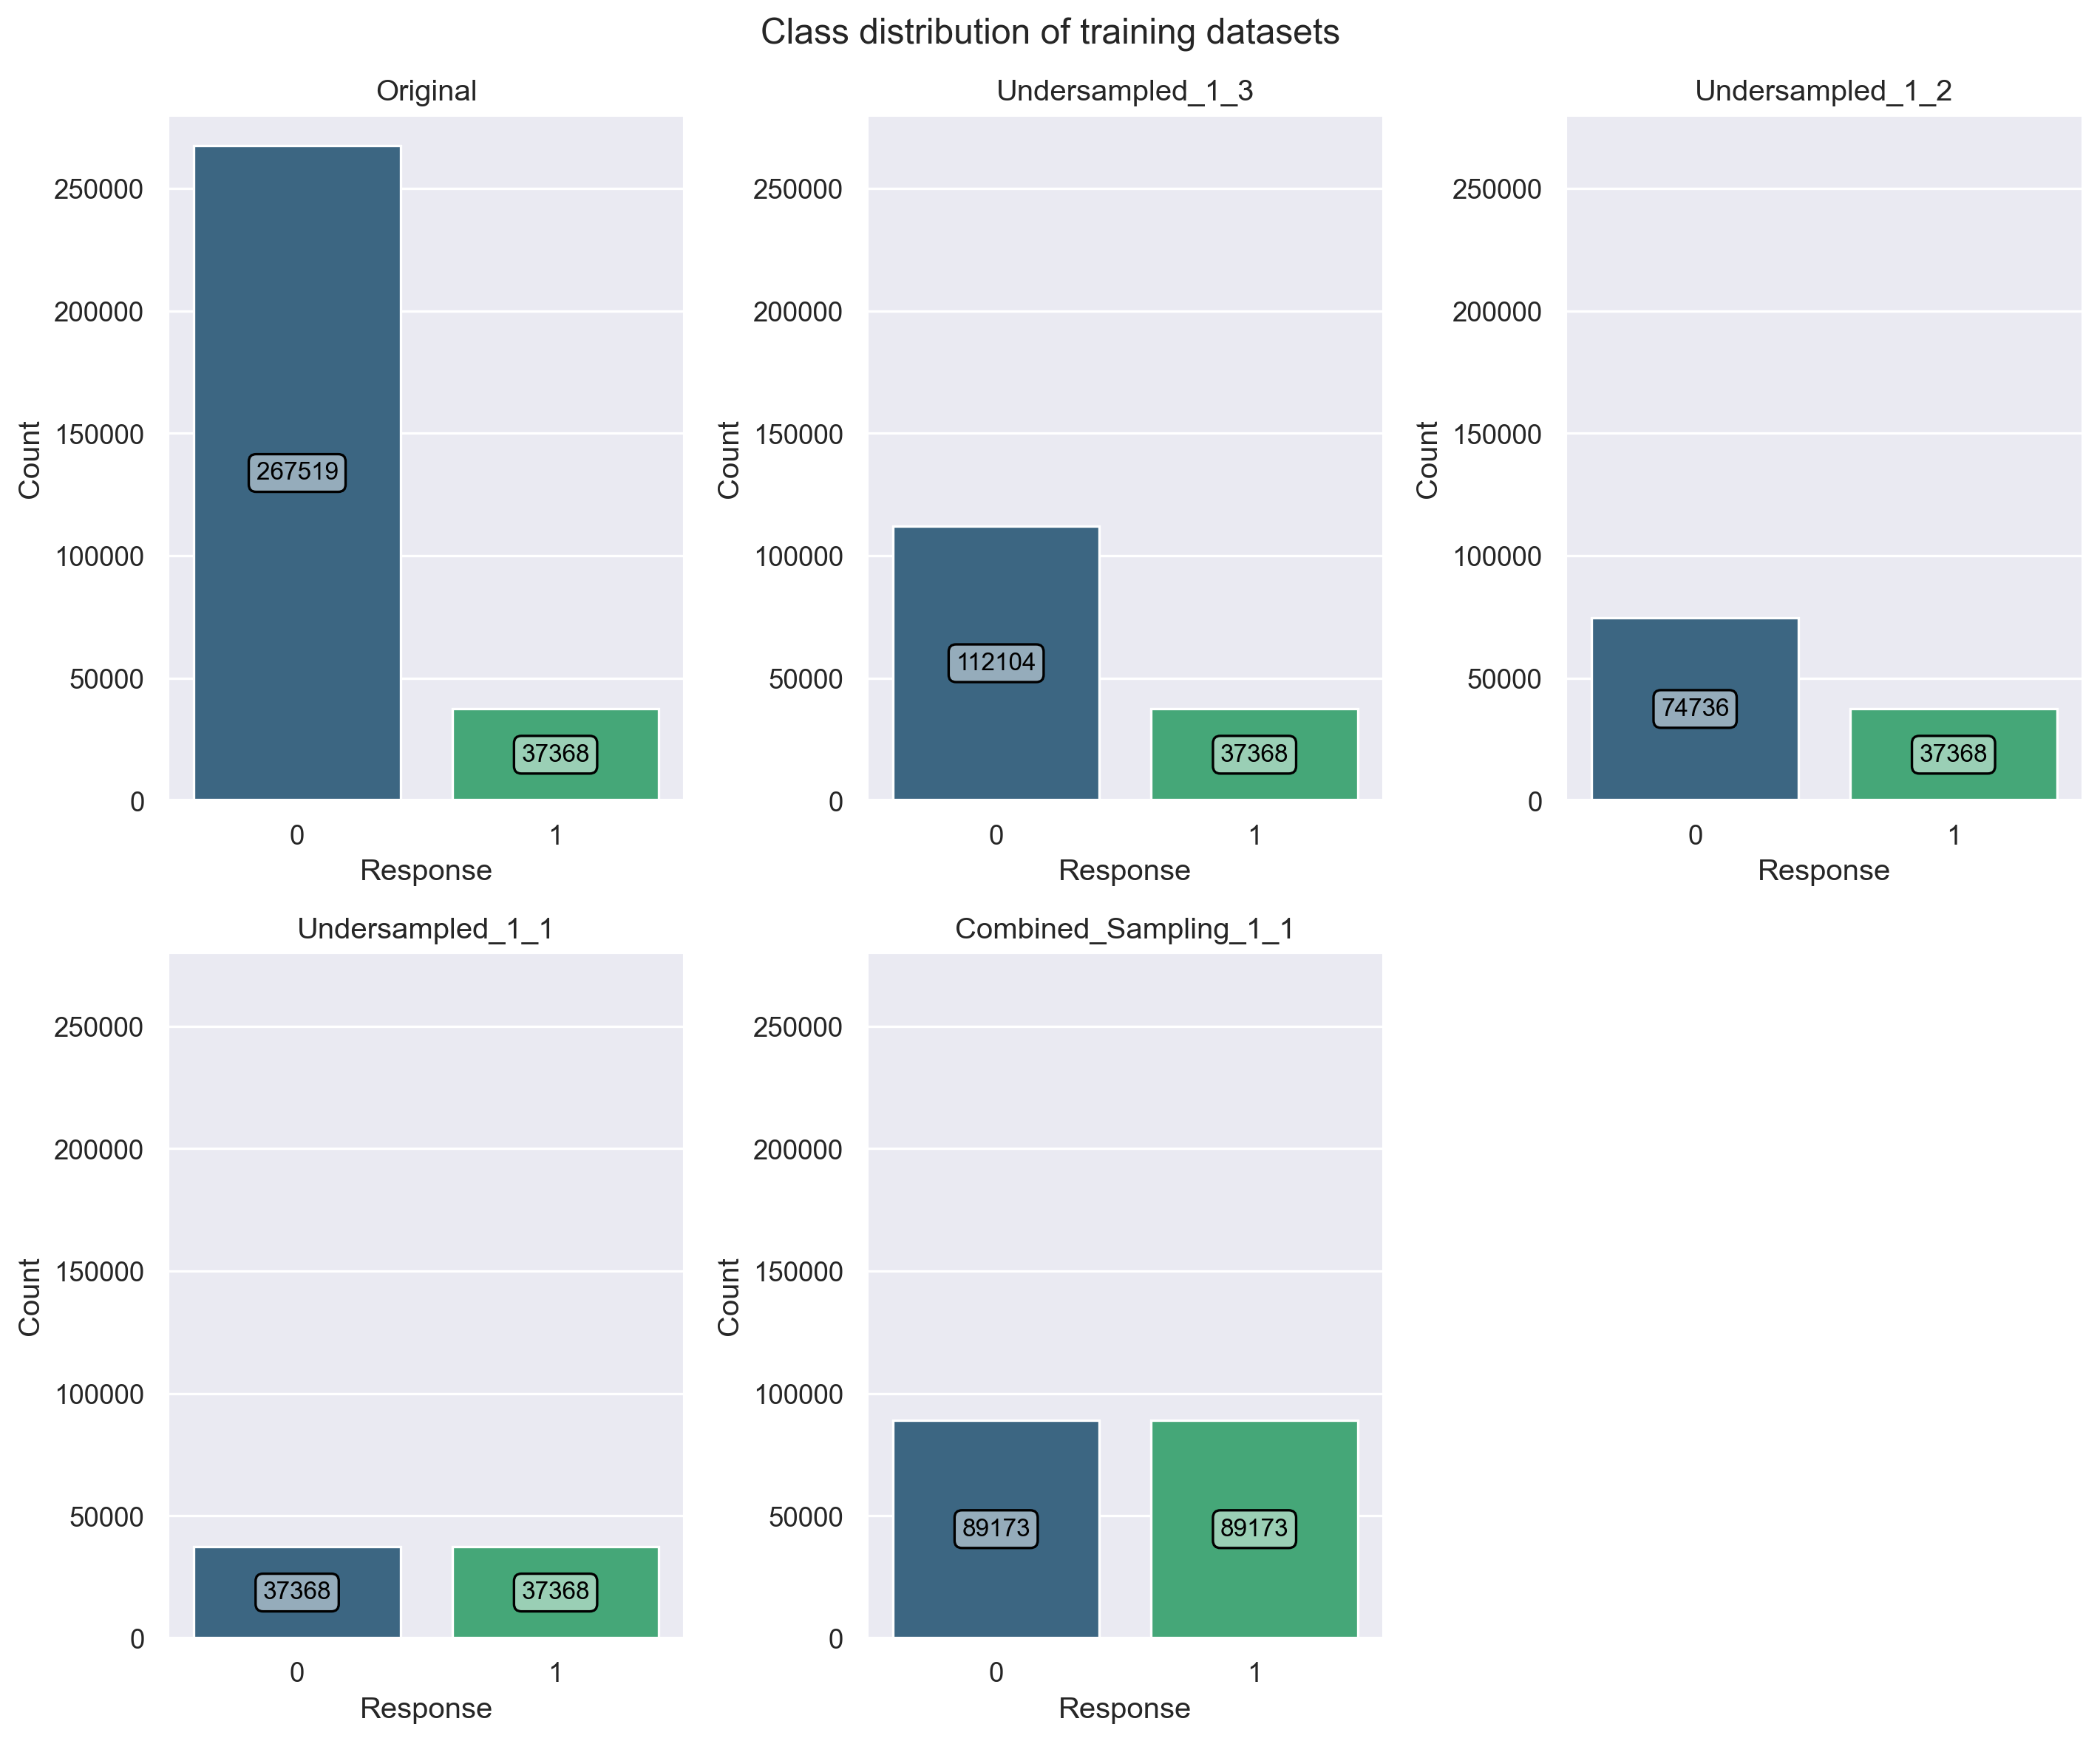

In [ ]:
# Count plots to visualize the distributions of 'Response' varible in the training datasets

plt.figure(figsize=(12, 10))

for i, dataset in enumerate(datasets.keys()):

    plt.subplot(2, 3, i+1)
    sns.countplot(x=datasets[dataset][1], hue=datasets[dataset][1], palette='viridis', legend=False)
    plt.ylim(0, 280000)
    plt.title(dataset, fontsize=12)
    plt.xlabel('Response')
    plt.ylabel('Count')

    for i, count in Counter(datasets[dataset][1]).items():
        plt.annotate(f"{count}", 
                     xy=(i, count/2), 
                     ha='center', va='center',
                     fontsize=10, color='black',
                     bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.suptitle("Class distribution of training datasets")
plt.tight_layout()
plt.show()

## Building the predictive model

In this section, a model will be built to predict the probability that a customer will give a positive response and identify the customers which are most likely to accept an additional insurance policy.

Three different classification algorithms will be trained and evaluated for all the training sets.

In [39]:
print("List of training datasets:")
for dataset in datasets.keys():
    print(f" - {dataset}")

List of training datasets:
 - Original
 - Undersampled_1_3
 - Undersampled_1_2
 - Undersampled_1_1
 - Combined_Sampling_1_1


In [40]:
# Define the test set (same for all models and training sets)
X_test = test_data.drop('Response', axis=1)
y_test = test_data['Response']
print(f"Test set with {X_test.shape[0]} samples")

Test set with 76222 samples


In [ ]:
# Define a function to train and evaluate model performance on all training datasets

def train_evaluate_model(datasets, model, X_test, y_test):

    results = {}

    for dataset, (X_train, y_train) in datasets.items():

        print(f"\nTraining model on {dataset} dataset")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {}
        metrics['accuracy'] = accuracy_score(y_test, y_pred)
        metrics['precision'] = precision_score(y_test, y_pred)
        metrics['recall'] = recall_score(y_test, y_pred)
        metrics['f1'] = f1_score(y_test, y_pred)
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        metrics['pr_auc'] = average_precision_score(y_test, y_pred_proba)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[dataset] = {
            'metrics': metrics,
            'confusion_matrix': cm,
            'predictions': y_pred_proba
        }

    print("\n---------")
    print("Completed")

    return results


In [67]:
# Define a function to plot confusion matrices from model results

def plot_confusion_matrices(model_name, model_results):
    
    plt.figure(figsize=(12, 9))

    for i, dataset in enumerate(model_results.keys()):

        plt.subplot(2, 3, i+1)
        sns.heatmap(model_results[dataset]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"""{dataset}\nPrecision: {model_results[dataset]['metrics']['precision']:.2f} - Recall: {model_results[dataset]['metrics']['recall']:.2f} (F1: {model_results[dataset]['metrics']['f1']:.2f})""")
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

    plt.suptitle(f"Confusion matrices of {model_name} models")
    plt.tight_layout()
    plt.show()

### Logistic Regression

The first algorithm considered is [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), a linear model for classification where the probabilities describing the possible outcomes are modeled using a logistic function.

In [110]:
# Train the model and calculate results

logistic_regression = LogisticRegression(class_weight="balanced")

logistic_regression_results = train_evaluate_model(datasets, logistic_regression, X_test, y_test)


Training model on Original dataset

Training model on Undersampled_1_3 dataset

Training model on Undersampled_1_2 dataset

Training model on Undersampled_1_1 dataset

Training model on Combined_Sampling_1_1 dataset

---------
Completed


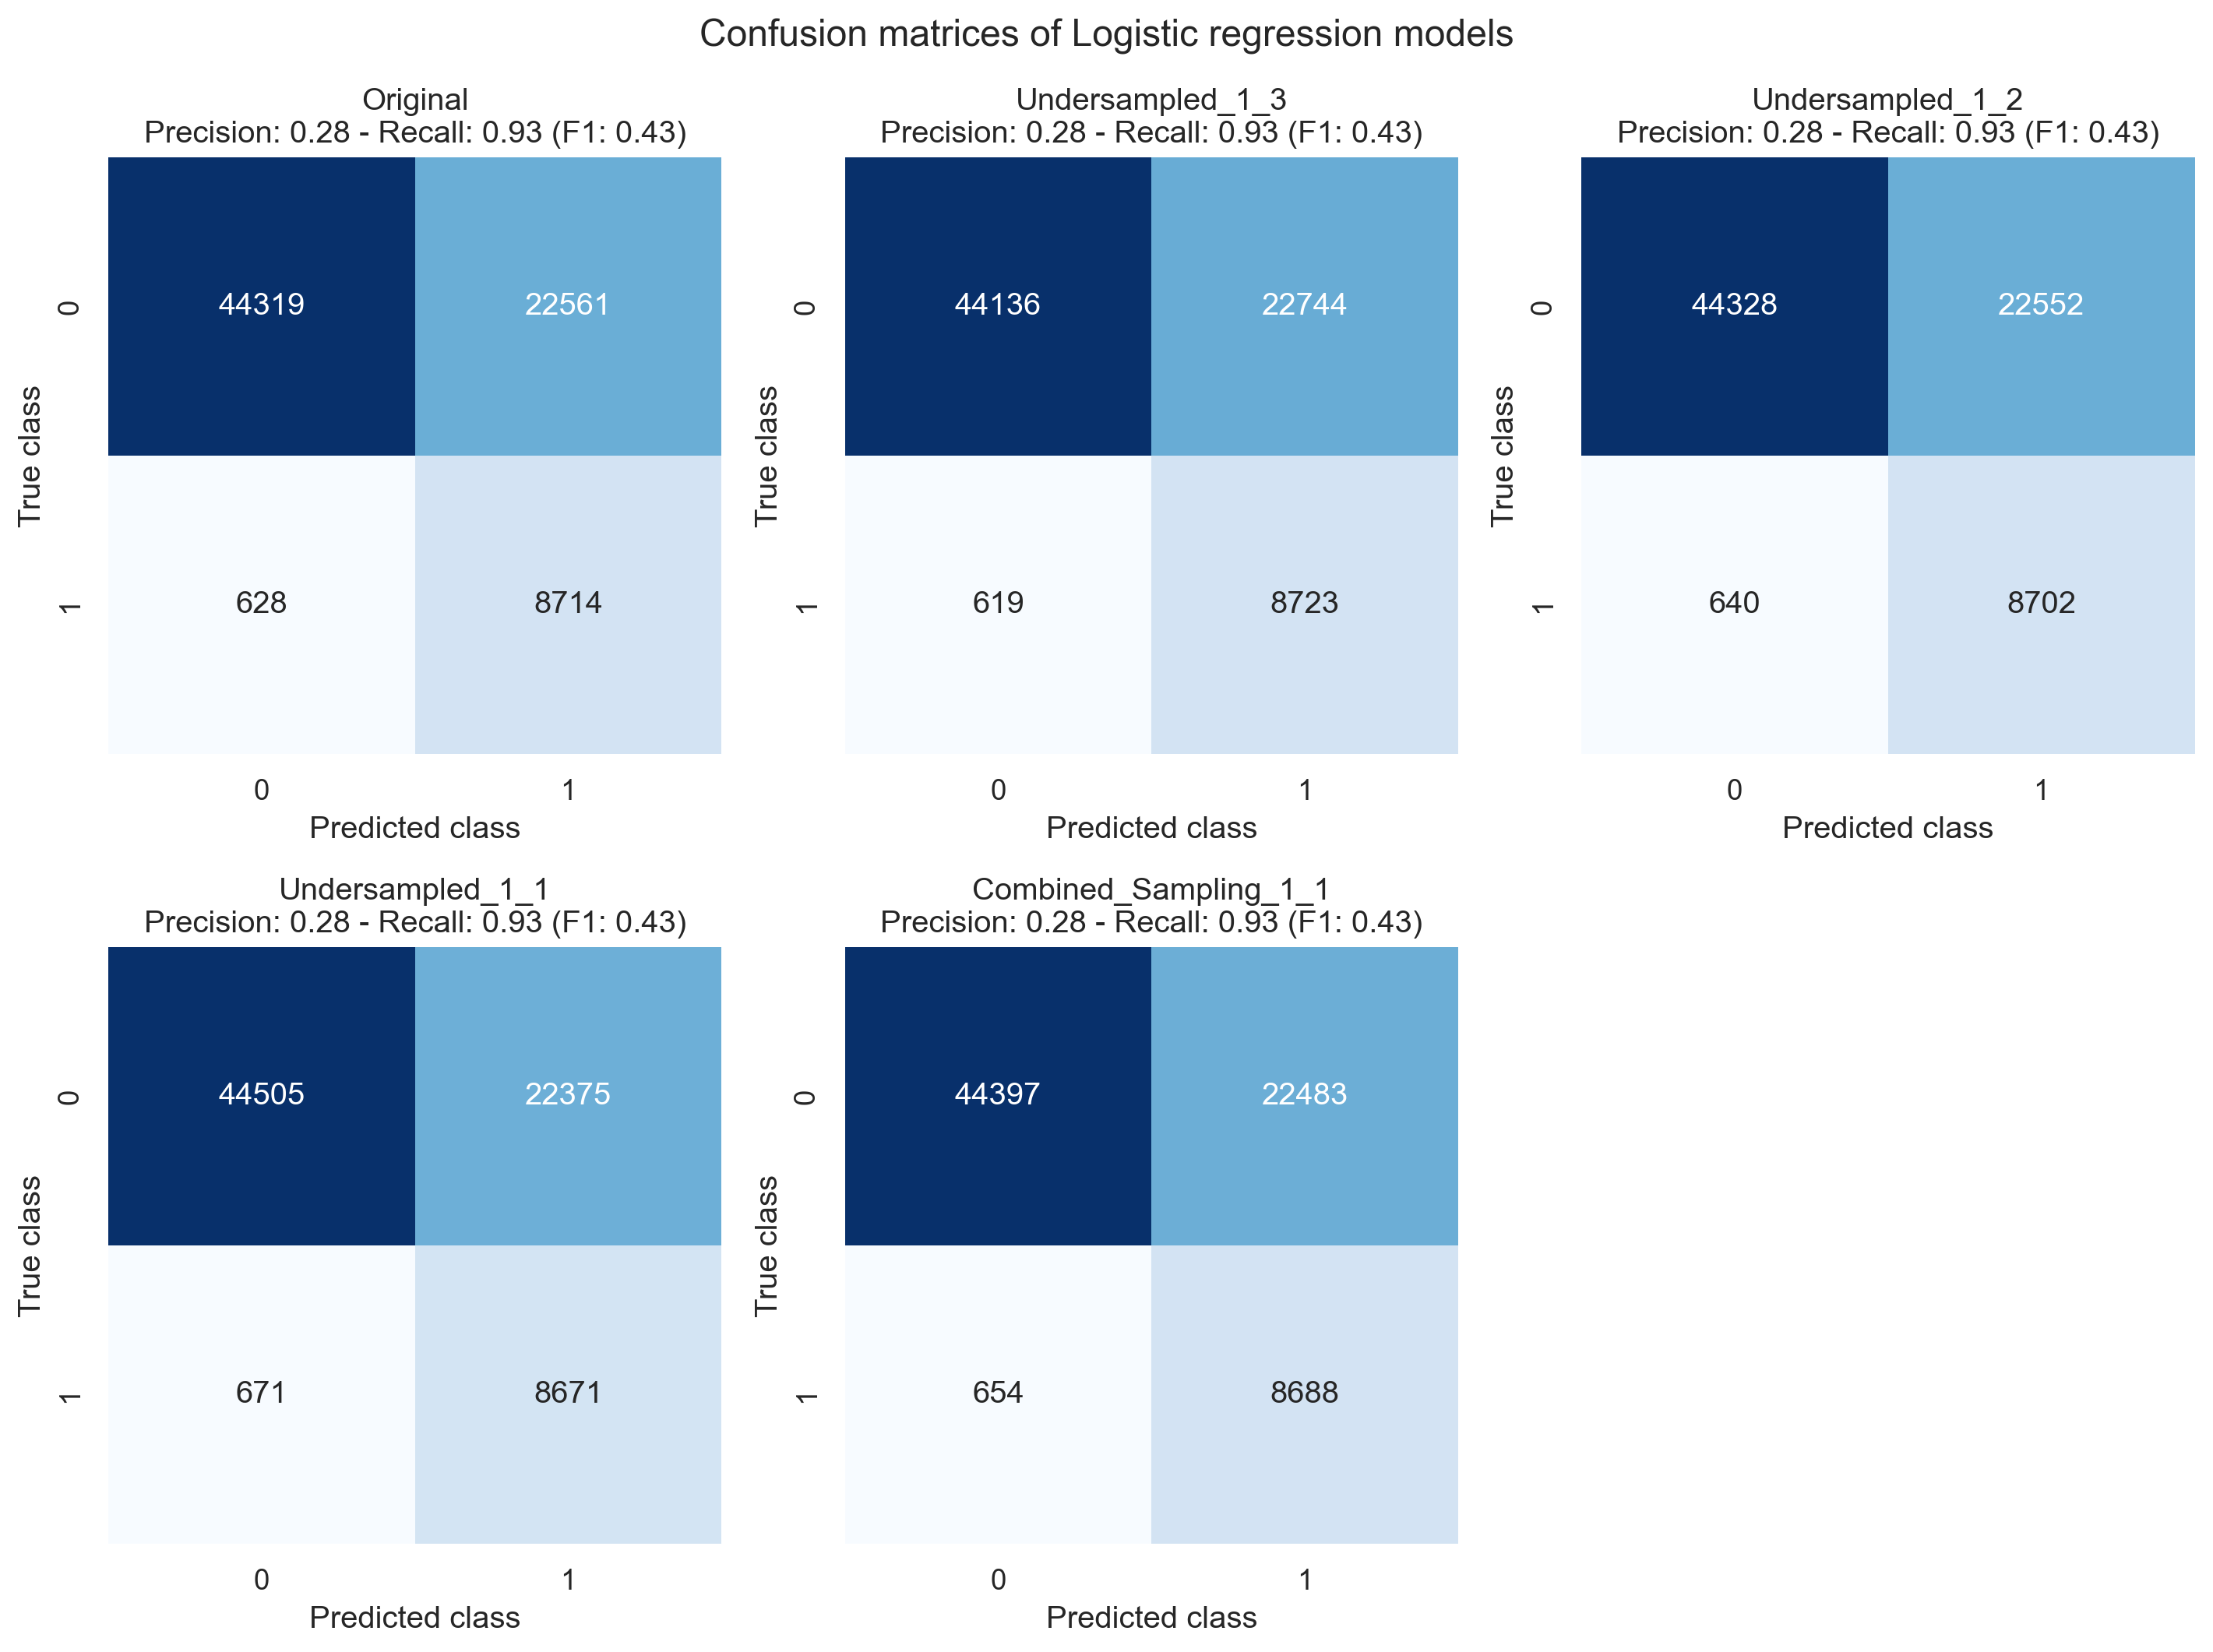

In [ ]:
# Plot confusion matrices

plot_confusion_matrices("Logistic regression", logistic_regression_results)

### K-Nearest Neighbors

The second algorithm considered is the [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), which addresses the classification problem with the nearest neighbor method. This approach consists in finding a predefined number (k) of training samples closest in distance to the new data point, and predict the class label from these. 

In [69]:
# Train the model and calculate results

k_nearest_neighbors = KNeighborsClassifier(n_neighbors=20)

k_nearest_neighbors_results = train_evaluate_model(datasets, k_nearest_neighbors, X_test, y_test)


Training model on Original dataset

Training model on Undersampled_1_3 dataset

Training model on Undersampled_1_2 dataset

Training model on Undersampled_1_1 dataset

Training model on Combined_Sampling_1_1 dataset

---------
Completed


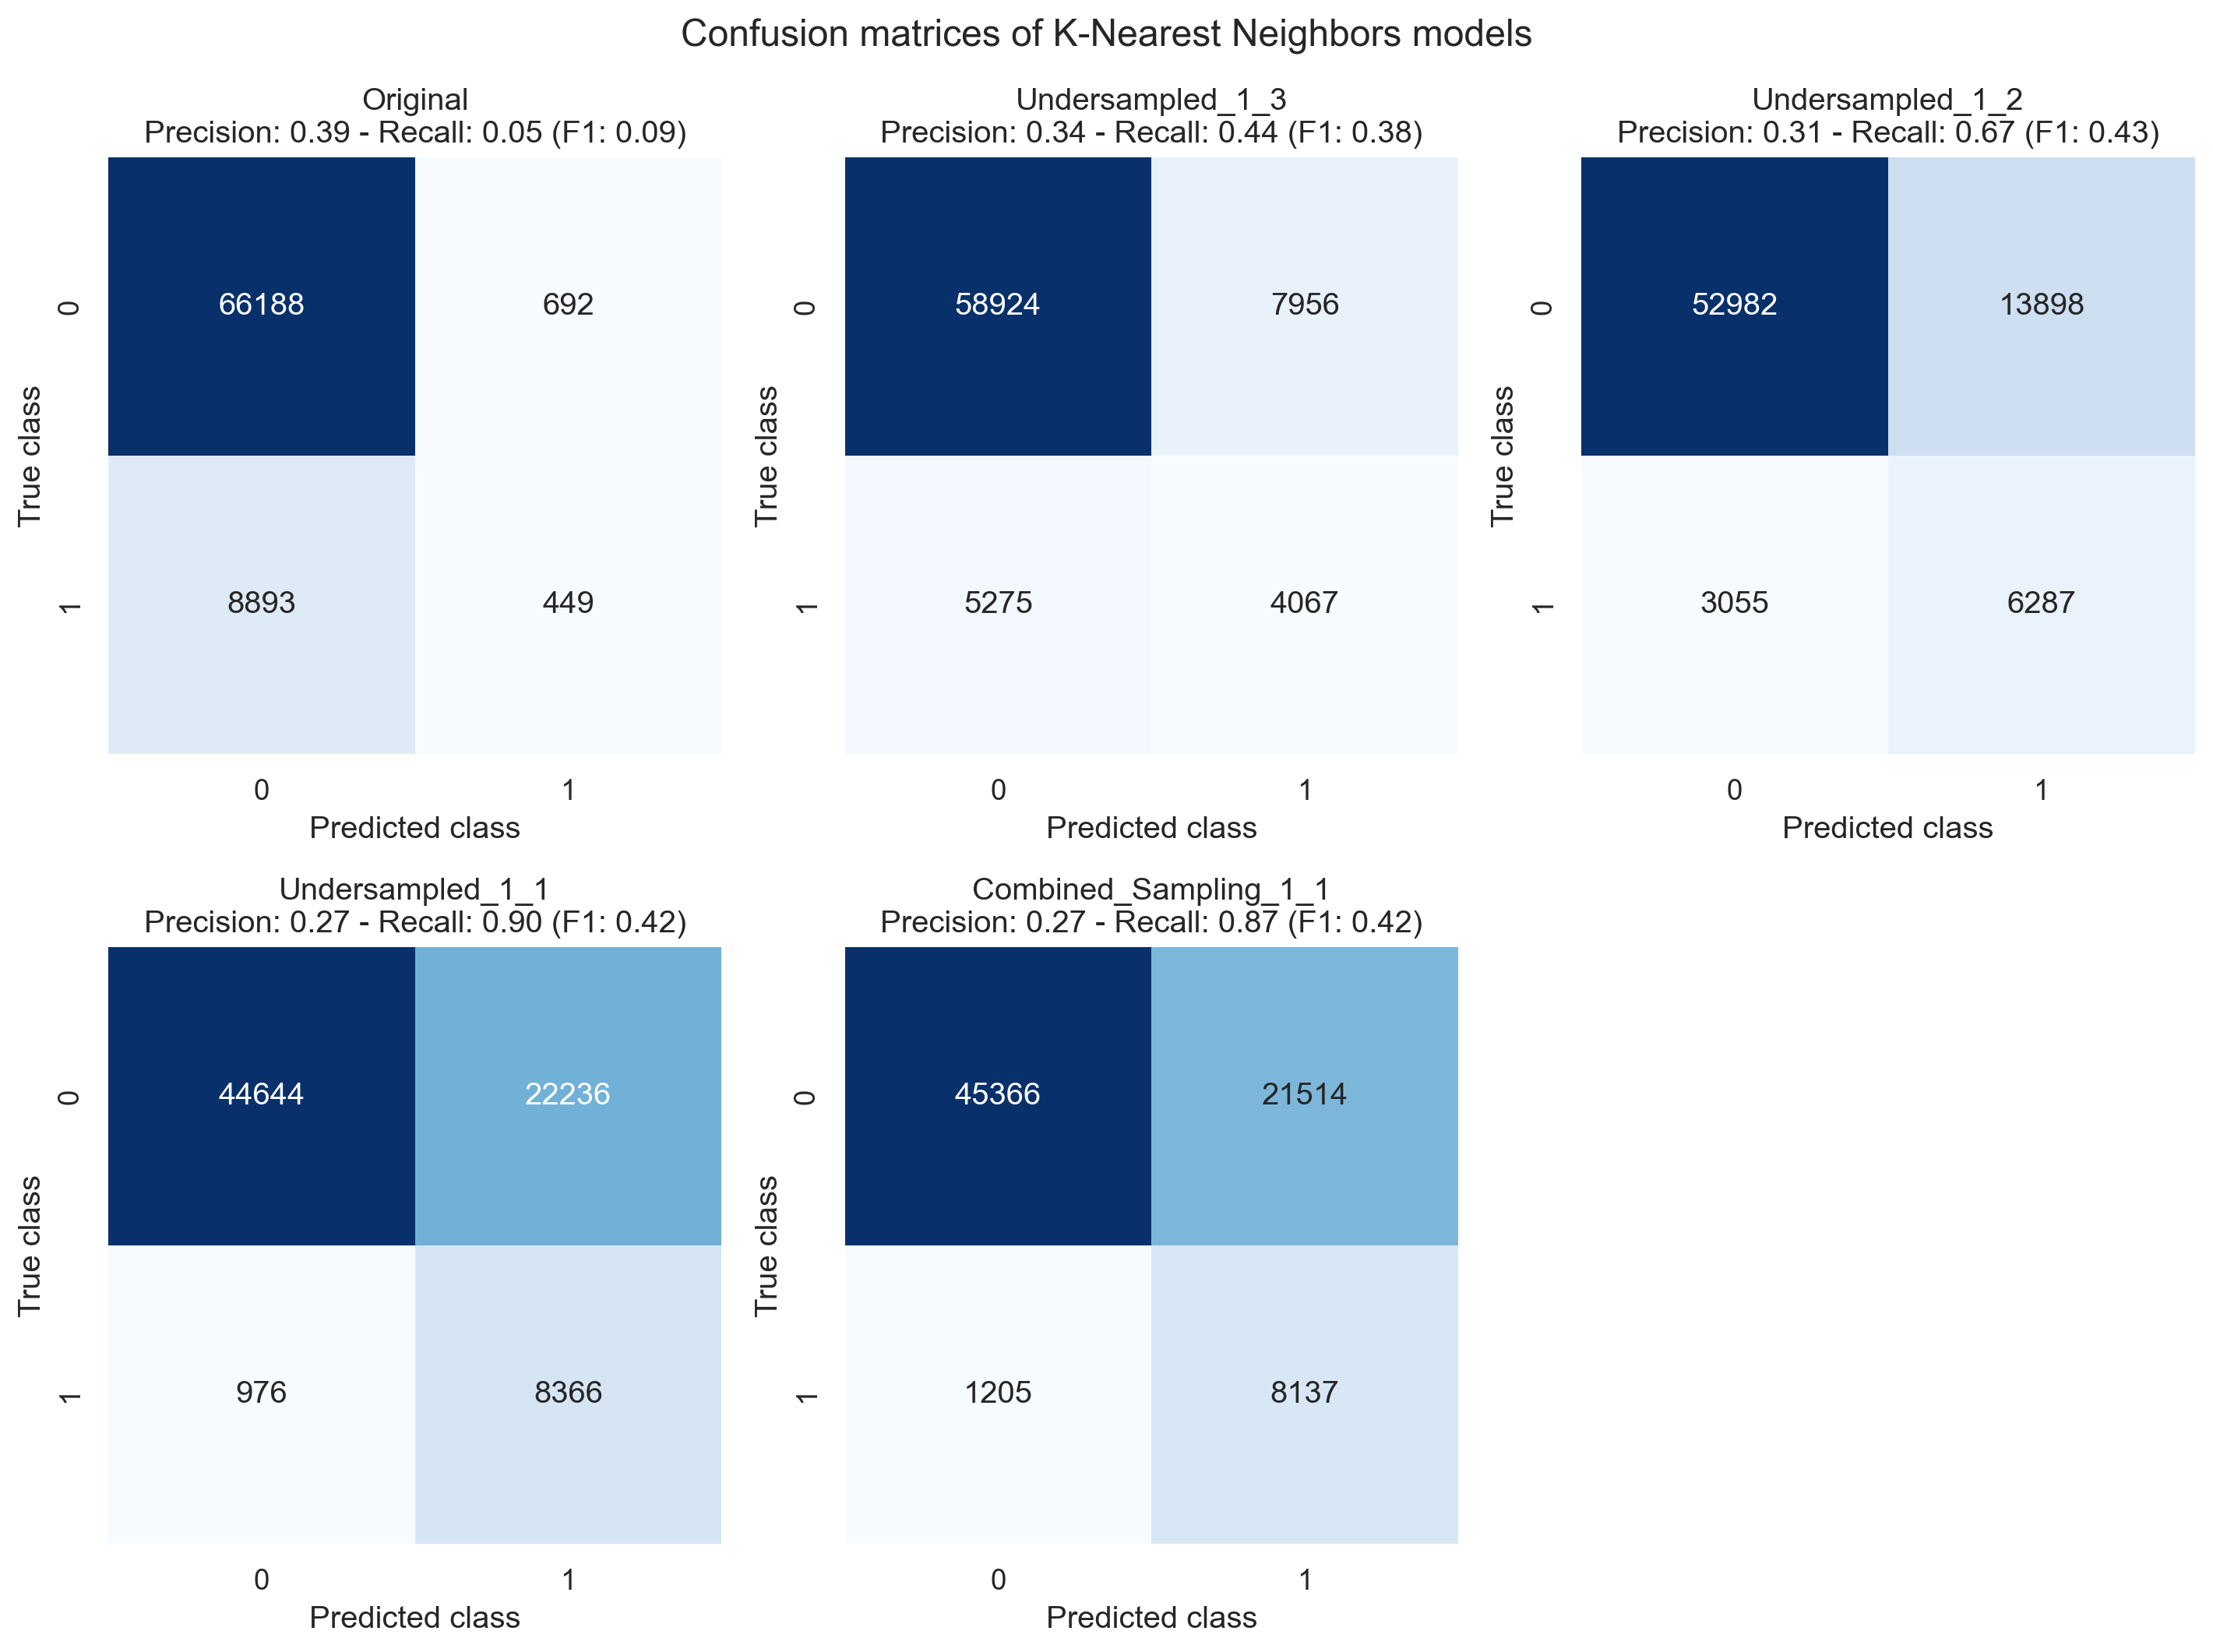

In [ ]:
# Plot confusion matrices

plot_confusion_matrices("K-Nearest Neighbors", k_nearest_neighbors_results)

### Random Forest

The third algorthm considered is [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), an ensemble machine learning algorithm which builds multiple decision trees during training (to predict the value of the target variable by learning  decision rules based on feature values) and combines their outputs to make the final prediction.

In [72]:
# Train the model and calculate results

random_forest = RandomForestClassifier(class_weight='balanced')

random_forest_results = train_evaluate_model(datasets, random_forest, X_test, y_test)


Training model on Original dataset

Training model on Undersampled_1_3 dataset

Training model on Undersampled_1_2 dataset

Training model on Undersampled_1_1 dataset

Training model on Combined_Sampling_1_1 dataset

---------
Completed


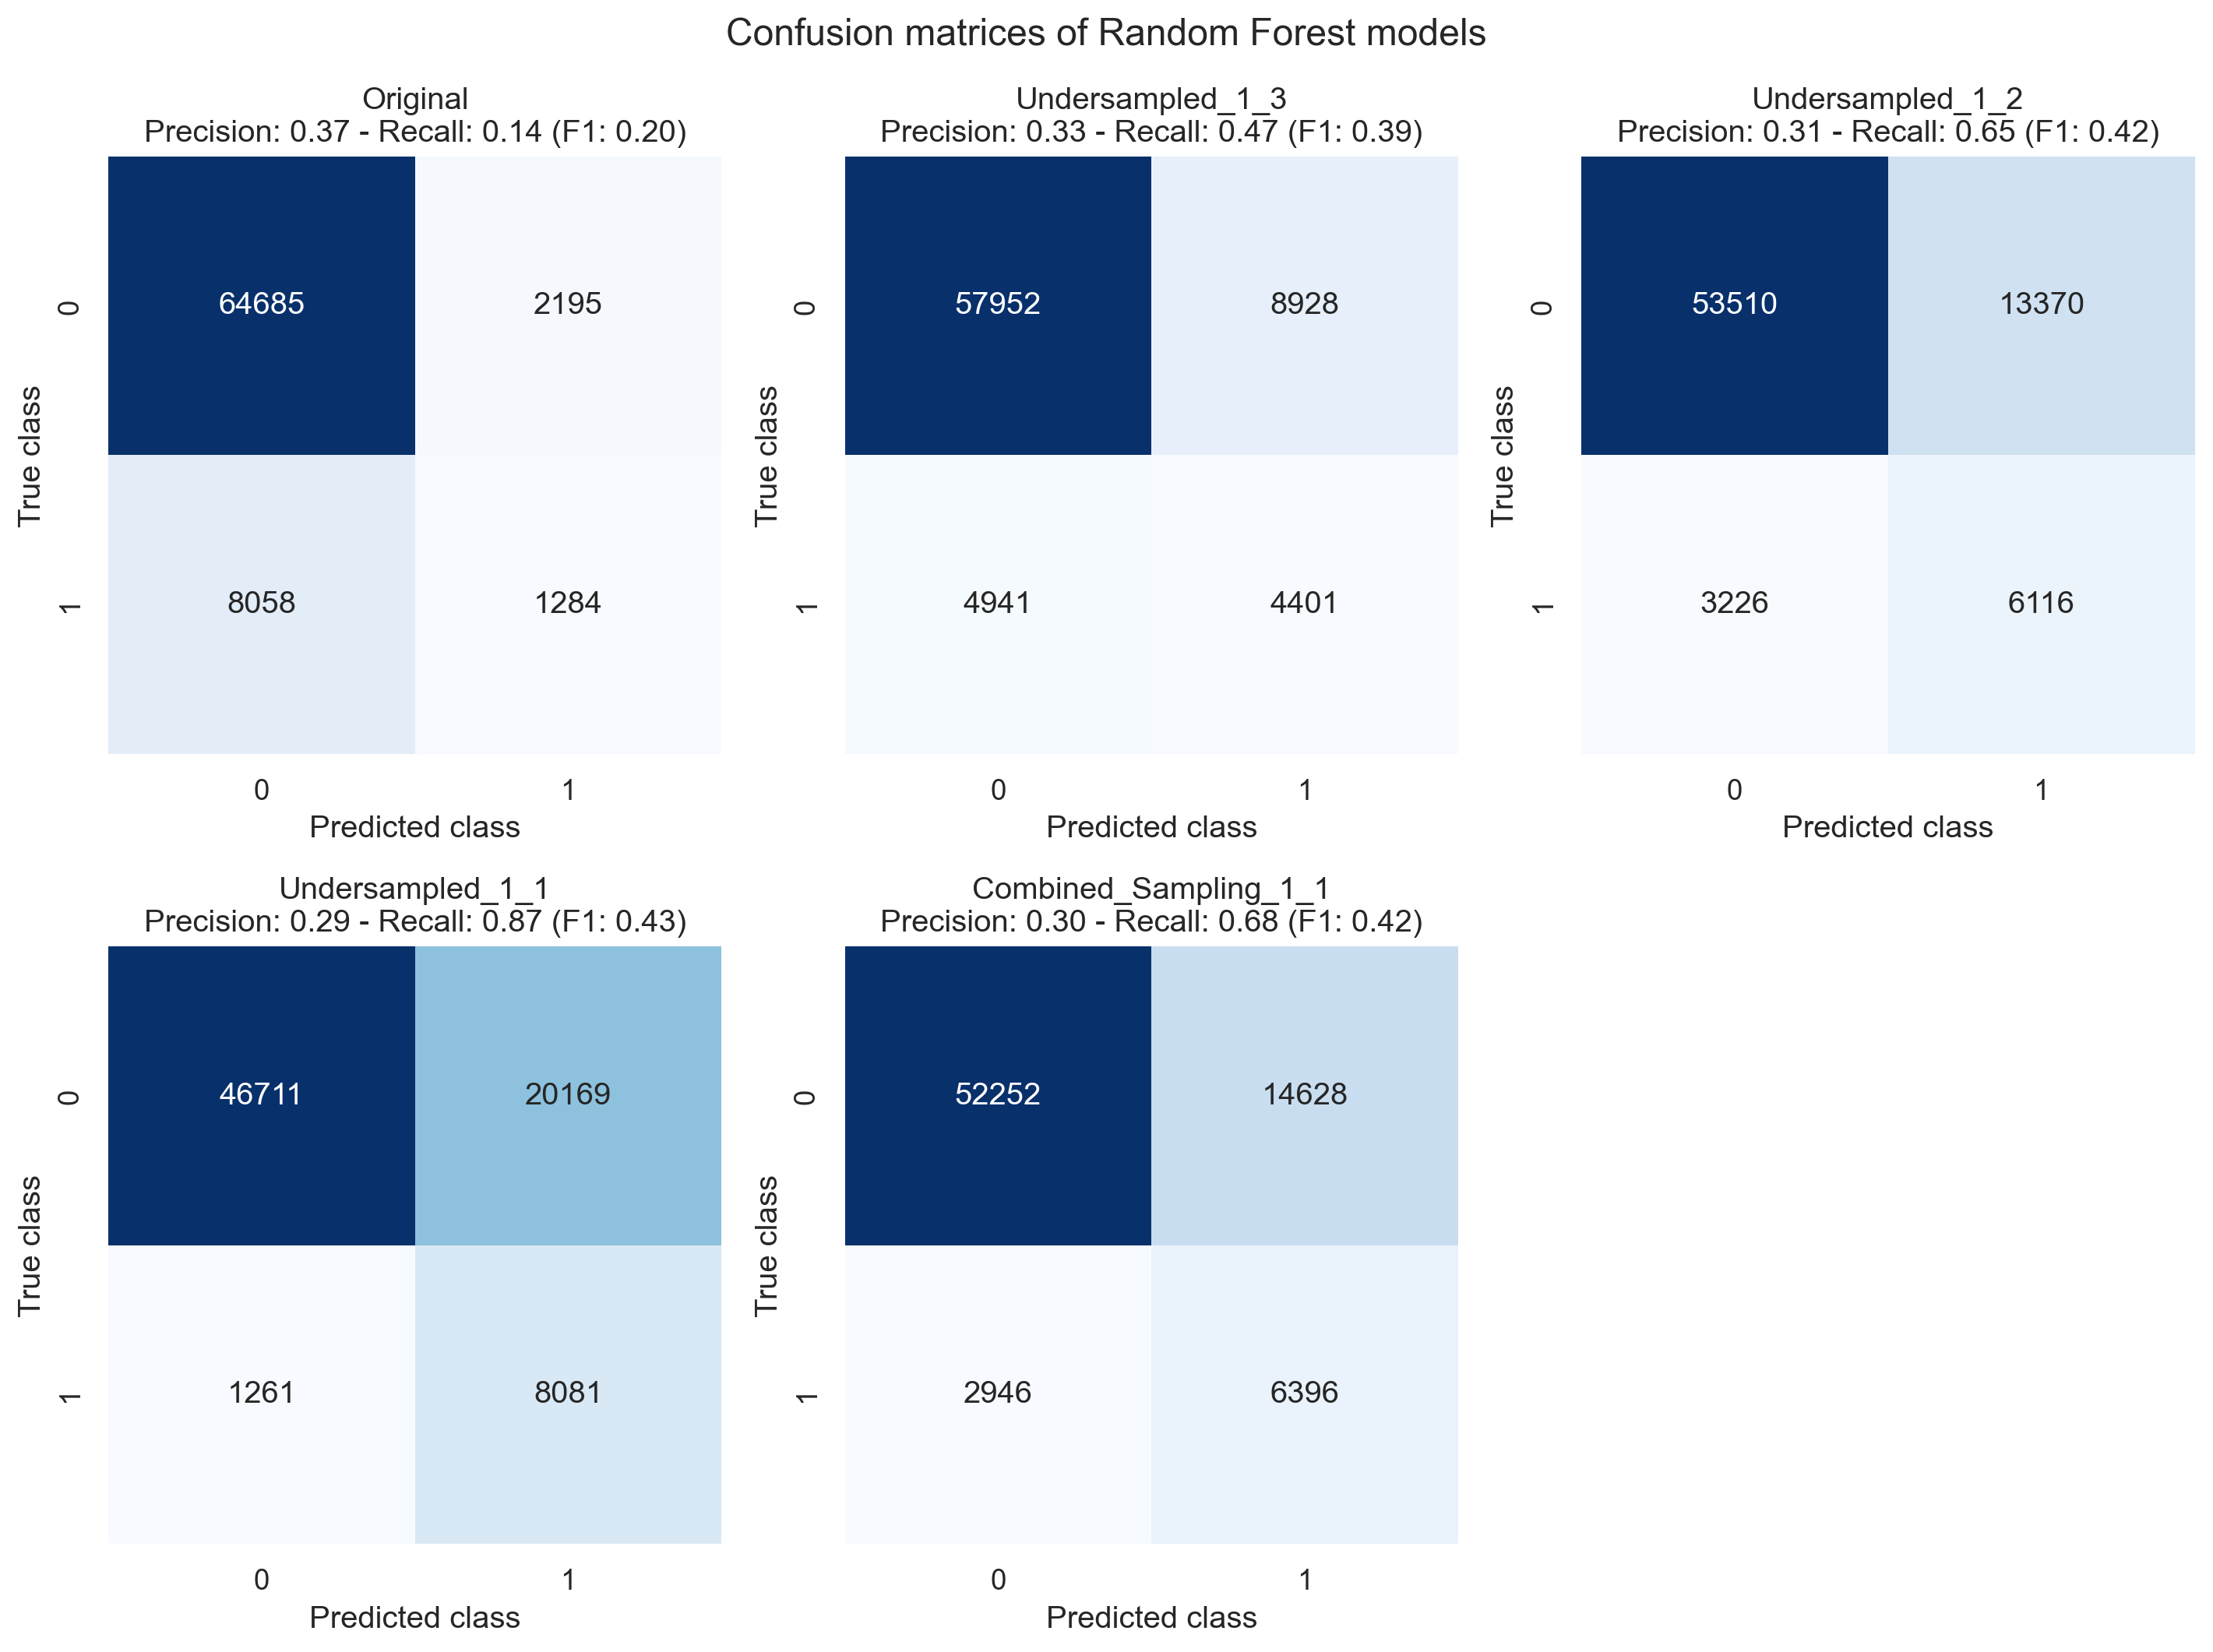

In [ ]:
# Plot confusion matrices

plot_confusion_matrices("Random Forest", random_forest_results)

### ROC curves and PR curves

By observing the results of evaluations, for a classification threshold of 0.5 (default value used for prediction), all the models achieved good recall values (about 0.9), especially with more balanced datasets, but low precision values (about 0.3), as they produced a relatively high proportion of false positives.

To better visualize the model performances, the ROC curves are calculated. The ROC curves are plots of the false positive rate versus the true positive rate for different classification thresholds values between 0.0 and 1.0.

In [78]:
all_results = {"Logistic regression": logistic_regression_results, 
               "K-Nearest Neighbors": k_nearest_neighbors_results, 
               "Random Forest": random_forest_results}

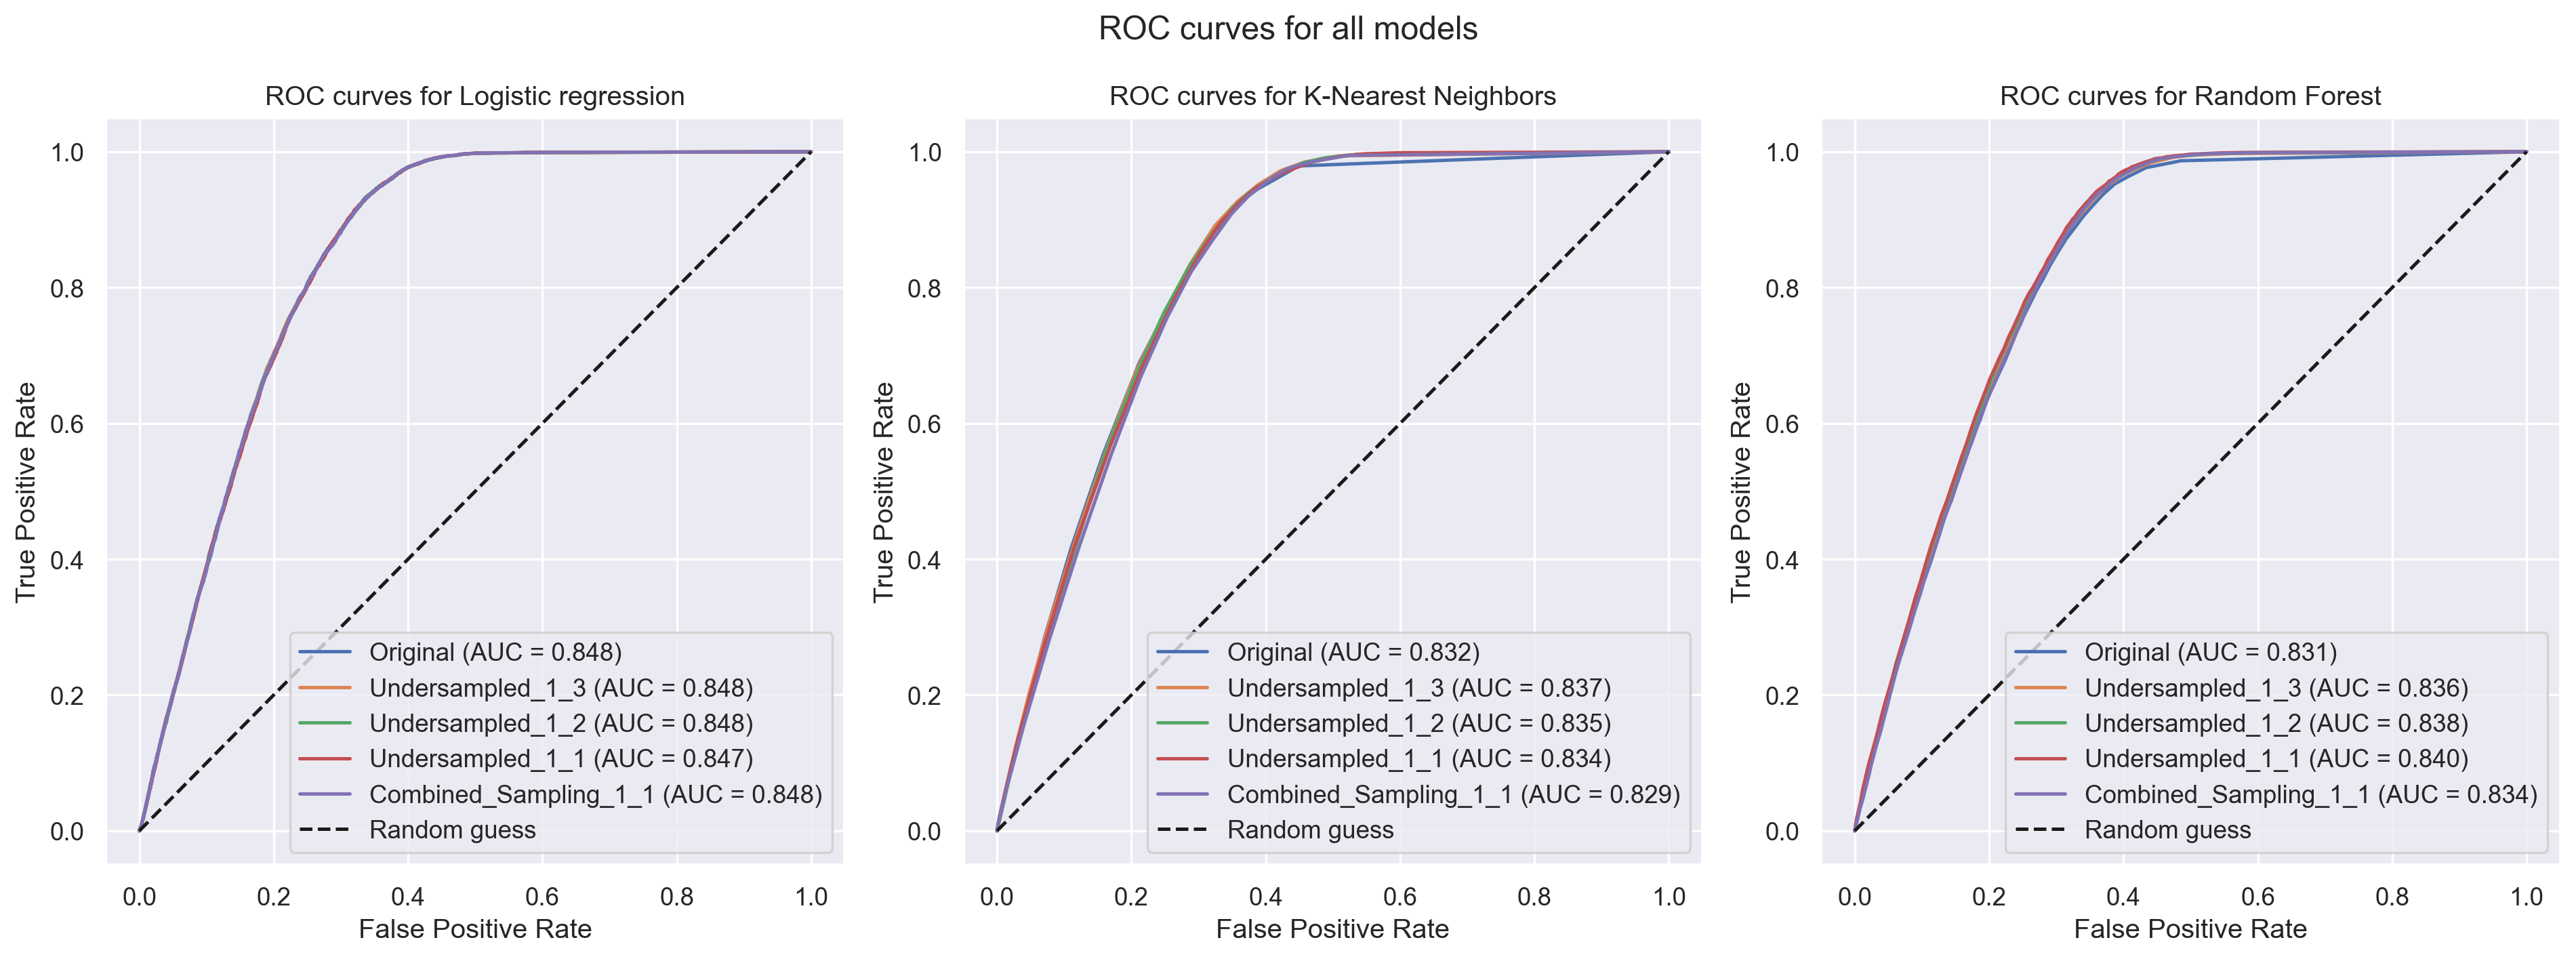

In [94]:
# Plot ROC curves from model results

plt.figure(figsize=(16, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 3, i+1)

    for i, dataset in enumerate(result.keys()):

        fpr, tpr, _ = roc_curve(y_test, result[dataset]["predictions"])
        plt.plot(fpr, tpr, label=f"{dataset} (AUC = {result[dataset]["metrics"]['roc_auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC curves for {name}")
    plt.legend(loc='lower right')
    plt.grid(True)

plt.suptitle(f"ROC curves for all models")
plt.tight_layout()
plt.show()

As the observations of the test dataset are strongly imbalanced (there are many samples of negative class respect to the positive class), it is more useful to calculate the precision-recall curves, which plot of the precision and the recall values for different classification thresholds. For imbalanced datasets, the precision-recall curve provides a more accurate picture of the classification performance as it evaluates the fraction of true positives among positive predictions.

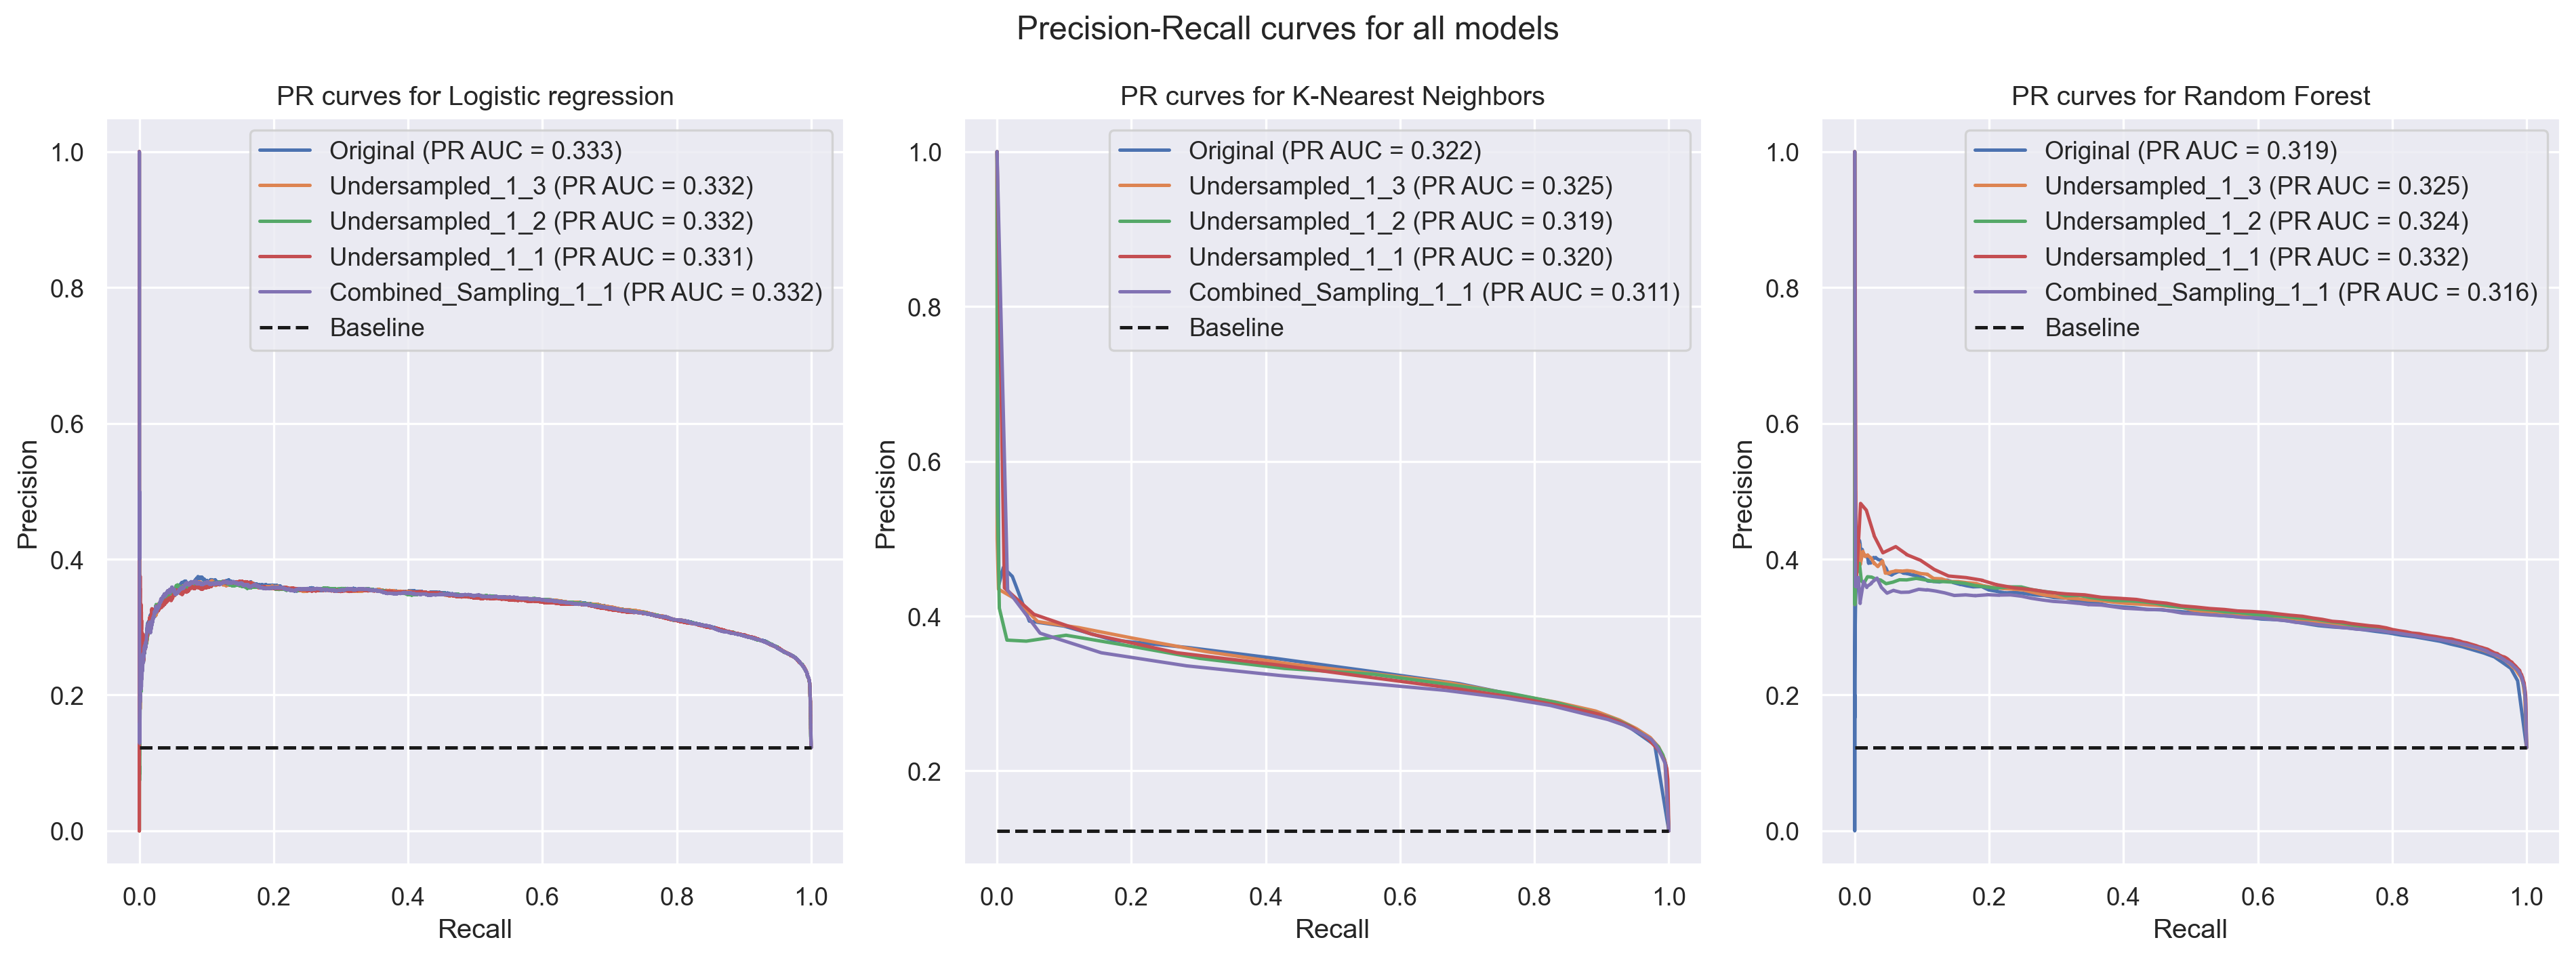

In [95]:
# Plot Precision-Recall curves from model results

plt.figure(figsize=(16, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 3, i+1)

    for i, dataset in enumerate(result.keys()):

        precision, recall, _ = precision_recall_curve(y_test, result[dataset]["predictions"])
        plt.plot(recall, precision, label=f"{dataset} (PR AUC = {result[dataset]["metrics"]['pr_auc']:.3f})")
    
    plt.plot([0, 1], [sum(y_test)/len(y_test)]*2, 'k--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"PR curves for {name}")
    plt.legend(loc='upper right')
    plt.grid(True)

plt.suptitle(f"Precision-Recall curves for all models")
plt.tight_layout()
plt.show()

Here can be observed that the AUC (area under the curve) values, which represent a summary of the model skills, are much lower in the precision-recall curves (about 0.3) respect to the ROC curves (about 0.8).

### Increased threshold

As noted before, for a classification threshold of 0.5, the evaluated models (when trained on balanced datasets) reult in high recall values (about 0.9). This can be considered a useful prediction if we want to obtain a low number of false negatives and we are not interested in the number of false positives. In fact, in this case we can identify a high possible number of customers likely interested in an additional insurance policy. However, if we want to reduce the false positives and identify only the customers which are most likely to accept the additional policy, we can increase the threshold used to predict the positive response.

Here, this procedure is applied to the results of the Logistic regression model, by increasing the threshold from the default value of 0.5 to 0.7.

In [ ]:
# Calculate predictions and metrics with increased threshold

threshold = 0.7

for dataset in logistic_regression_results.keys():

    y_pred_proba = logistic_regression_results[dataset]['predictions']
    y_pred = np.where(y_pred_proba>threshold, 1, 0)

    logistic_regression_results[dataset]['metrics']['accuracy'] = accuracy_score(y_test, y_pred)
    logistic_regression_results[dataset]['metrics']['precision'] = precision_score(y_test, y_pred)
    logistic_regression_results[dataset]['metrics']['recall'] = recall_score(y_test, y_pred)
    logistic_regression_results[dataset]['metrics']['f1'] = f1_score(y_test, y_pred)

    logistic_regression_results[dataset]['confusion_matrix'] = confusion_matrix(y_test, y_pred)


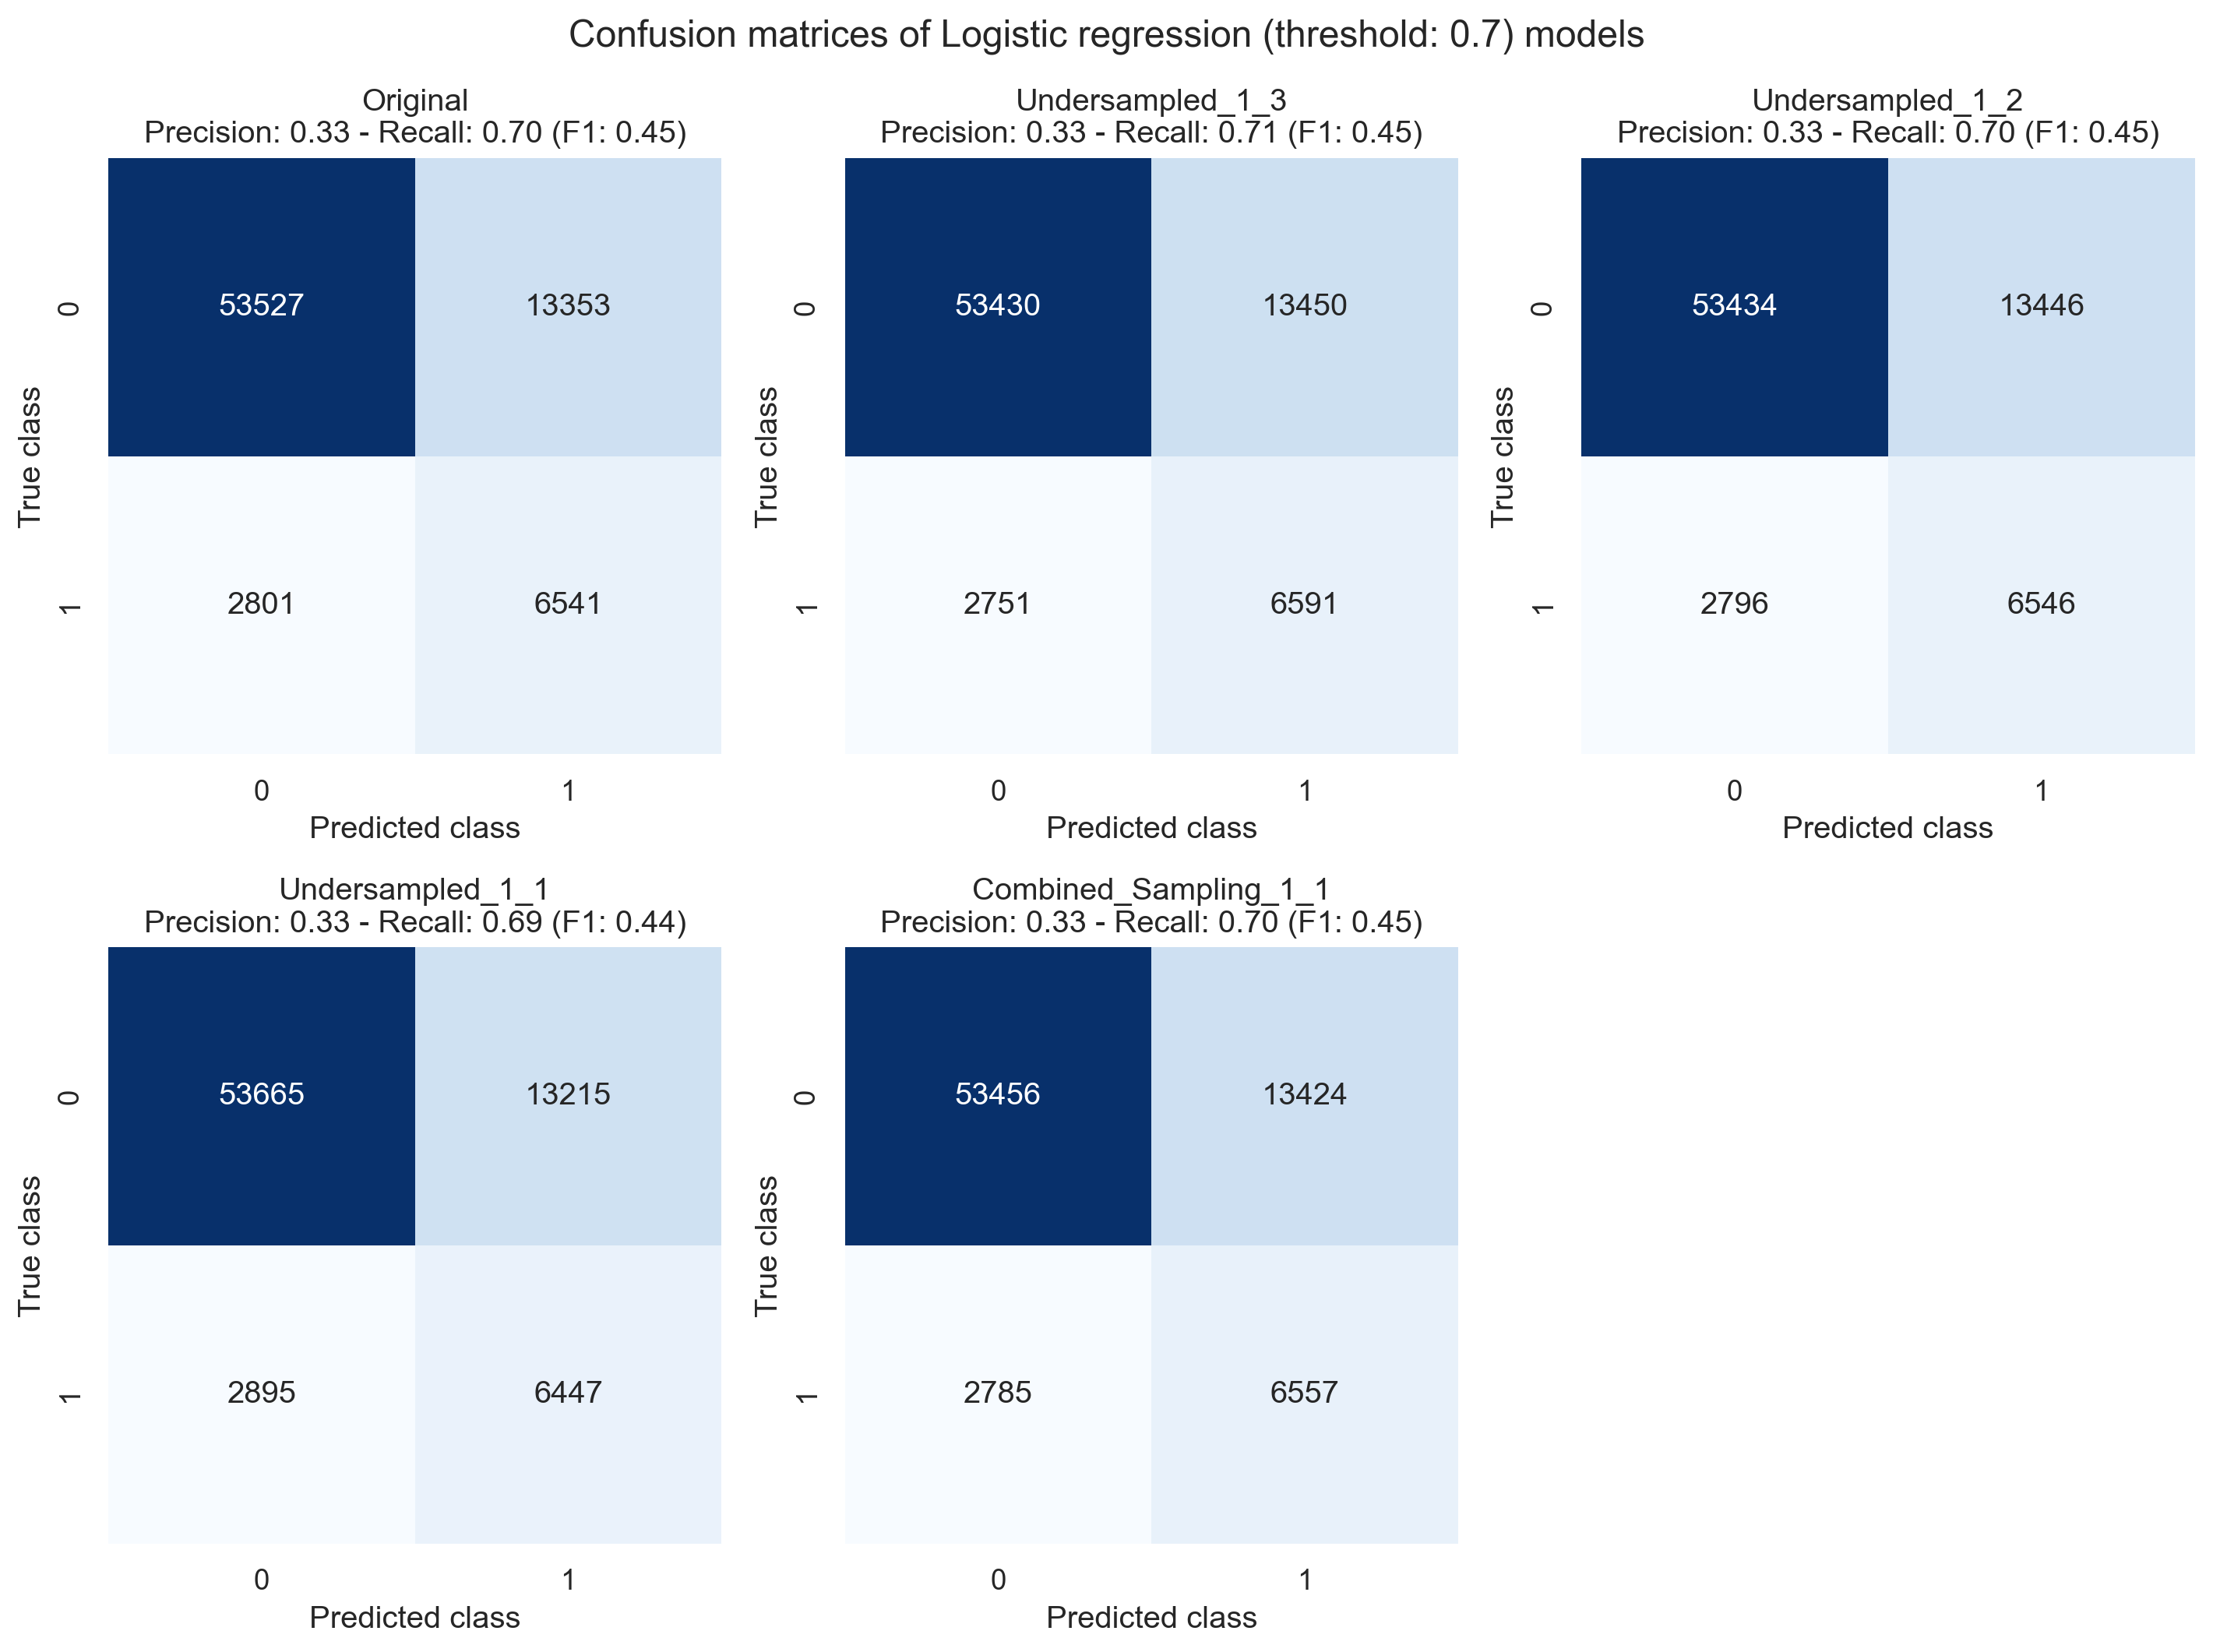

In [ ]:
# Plot confusion matrices

plot_confusion_matrices("Logistic regression (threshold: 0.7)", logistic_regression_results)

As can be observed, respect to the default predictions of the Logistic regression models, here the number of false positives is reduced while the number of false negatives is increased, as only customers with probability >0.7 are predicted to give a positive response.